In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import seaborn
import shapely
import rioxarray
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
resolution = 10
horizontal_crs = 2193

### Load in GeoFabrics Bathymetry estimates

In [14]:
cache_path = pathlib.Path(r"C:\Local\data\catchments\Waikanae\caches")
folder = "paper"
dems = {}
dems["conceptual multivariate regression"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_4m_river.nc", masked=True).squeeze("band", drop=True)
dems["Unconditioned"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_4m_unconditioned.nc", masked=True).squeeze("band", drop=True)

In [10]:
river_centreline = geopandas.read_file(cache_path / folder / "river" / r"aligned_river_centreline_100000000.geojson")
river_polygon = geopandas.read_file(cache_path / folder / "river" / "river_polygon.geojson")
fan_polygon = geopandas.read_file(cache_path / folder / "river" / "fan_polygon.geojson")

In [11]:
polygon = geopandas.GeoDataFrame( pandas.concat([river_polygon, fan_polygon], ignore_index=True), crs=river_polygon.crs).dissolve()

## Load in Measured cross sections
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [12]:
cross_section_elevation_label = 'Level'
cross_section_name_label = 'Section'
measured_sections = geopandas.read_file(r"C:\Local\data\river_bathemetry\sections\Waikanae\Waikanae_Cross_Sections_NIWA\2014_Survey_XS_NZVD2016.geojson")

In [13]:
measured_sections.head(1)

Number Source  Section  Offset    Northing     Easting  Level Code  \
0  10001.0      C     10.0     0.0  6035173.66  2679120.52   2.52   CP   

         Date  Upstream  lvd_conversion    z_2016  \
0  20141022.0       0.0        0.356669  2.163331   

                                  geometry  
0  POINT Z (1769102.282 5473458.894 2.163)

### Simplify the measured points to min point/line strings

In [15]:
measured_centres = {'Section': [], 'geometry': []}
measured_lines = {'Section': [], 'geometry': [], 'min_elevation': []}
for section in measured_sections[cross_section_name_label].unique():
    measured_section = measured_sections[measured_sections[cross_section_name_label] == section]
    measured_centre = measured_section[measured_section[cross_section_elevation_label]==measured_section['Level'].min()].iloc[0]
    measured_centres['Section'].append(section)
    measured_centres['geometry'].append(measured_centre['geometry'])
    
    measured_lines['Section'].append(section)
    measured_lines['geometry'].append(shapely.geometry.LineString( [[measure_point.x, measure_point.y, measure_point.z] for measure_point in measured_section.geometry.values] ))
    measured_lines['min_elevation'].append(measured_section[cross_section_elevation_label].min())
measured_centres = geopandas.GeoDataFrame(measured_centres, crs=horizontal_crs)
measured_lines = geopandas.GeoDataFrame(measured_lines, crs=horizontal_crs)

## Sample DEM for elevations
Record the Bias and STDev for each cross section against the two DEMS

<Axes: >

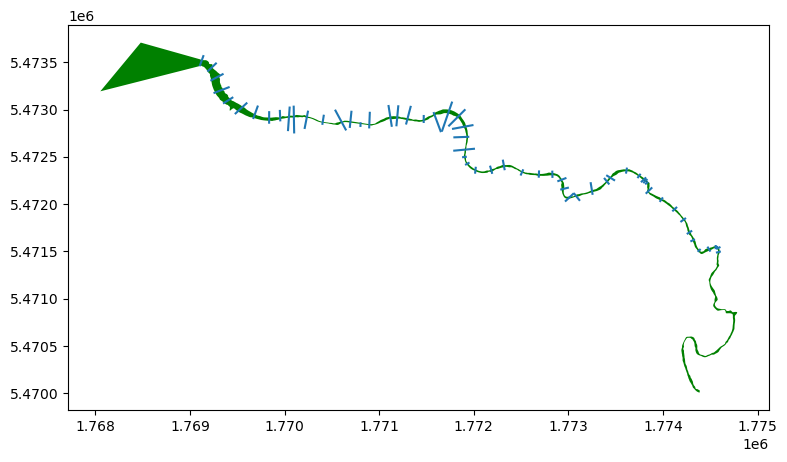

In [17]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 5))
polygon.plot(ax=ax, color='g')
measured_lines.plot(ax=ax)

# Sample every 1m
Use Linear interpolation in between

In [18]:
comparisons_sampled = {**dict((f"{key} z", []) for key in dems), **{"Measured Section z": [], "Section": [], "River": [], "Distance Upstream [m]": [], "Offset [m]": []}}
for index, row in measured_lines.iterrows():
    print(f"Section number = {index}")
    line = row.geometry
    distance_upstream = float(river_centreline.project(measured_centres.iloc[index].geometry))
    for offset in list(range(int(numpy.ceil(line.length)))):
        point = line.interpolate(offset)
        for key in dems:
            comparisons_sampled[f"{key} z"].append(float(dems[key].z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Measured Section z"].append(point.z)
        comparisons_sampled["Section"].append(row['Section'])
        comparisons_sampled["River"].append(polygon.iloc[0].geometry.contains(point))
        comparisons_sampled["Distance Upstream [m]"].append(distance_upstream)
        comparisons_sampled["Offset [m]"].append(offset)
        
comparisons_sampled = pandas.DataFrame.from_dict(comparisons_sampled)

Section number = 0
Section number = 1
Section number = 2
Section number = 3
Section number = 4
Section number = 5
Section number = 6
Section number = 7
Section number = 8
Section number = 9
Section number = 10
Section number = 11
Section number = 12
Section number = 13
Section number = 14
Section number = 15
Section number = 16
Section number = 17
Section number = 18
Section number = 19
Section number = 20
Section number = 21
Section number = 22
Section number = 23
Section number = 24
Section number = 25
Section number = 26
Section number = 27
Section number = 28
Section number = 29
Section number = 30
Section number = 31
Section number = 32
Section number = 33
Section number = 34
Section number = 35
Section number = 36
Section number = 37
Section number = 38
Section number = 39
Section number = 40
Section number = 41
Section number = 42
Section number = 43
Section number = 44
Section number = 45
Section number = 46
Section number = 47
Section number = 48
Section number = 49
Section nu

# Plot sampled elevations along entire sections
Plot the sampled elevations along individual cross-sections including the on-land portions as a sanity check.

In [58]:
comparisons_sampled

conceptual multivariate regression z  Unconditioned z  \
0                                 2.422087         2.422087   
1                                 2.218848         2.348687   
2                                 2.004279         2.286727   
3                                 1.796778         2.238703   
4                                 1.596319         2.204595   
...                                    ...              ...   
7419                             39.670518        39.670518   
7420                             39.806459        39.806459   
7421                             39.950095        39.950095   
7422                             39.960339        39.960339   
7423                             39.894148        39.894148   

      Measured Section z  Section  River  Distance Upstream [m]  Offset [m]  \
0               2.163331     10.0  False               5.905348           0   
1               2.165290     10.0  False               5.905348           1   
2               2.090118     10.0   True               5.905348           2   
3               2.062449     10.0   True               5.905348           3   
4               2.181504     10.0   True               5.905348           4   
...                  ...      ...    ...                    ...         ...   
7419           38.751469    550.0  False            7090.806857          49   
7420           39.228026    550.0  False            7090.806857          50   
7421           39.704582    550.0  False            7090.806857          51   
7422           39.780193    550.0  False            7090.806857          52   
7423           39.748018    550.0  False            7090.806857          53   

      conceptual multivariate regression Elevation Errors  \
0                                              0.258757     
1                                              0.053558     
2                                             -0.085838     
3                                             -0.265670     
4                                             -0.585184     
...                                                 ...     
7419                                           0.919049     
7420                                           0.578434     
7421                                           0.245513     
7422                                           0.180146     
7423                                           0.146130     

      Unconditioned Elevation Errors  
0                           0.258757  
1                           0.183397  
2                           0.196609  
3                           0.176254  
4                           0.023092  
...                              ...  
7419                        0.919049  
7420                        0.578434  
7421                        0.245513  
7422                        0.180146  
7423                        0.146130  

[7424 rows x 9 columns]

In [63]:
comparisons_sampled[comparisons_sampled["Section"]==section]['Distance Upstream [m]'].iloc[0]

7090.806856940876

C:\Users\pearsonra\Anaconda3\envs\raster\Lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


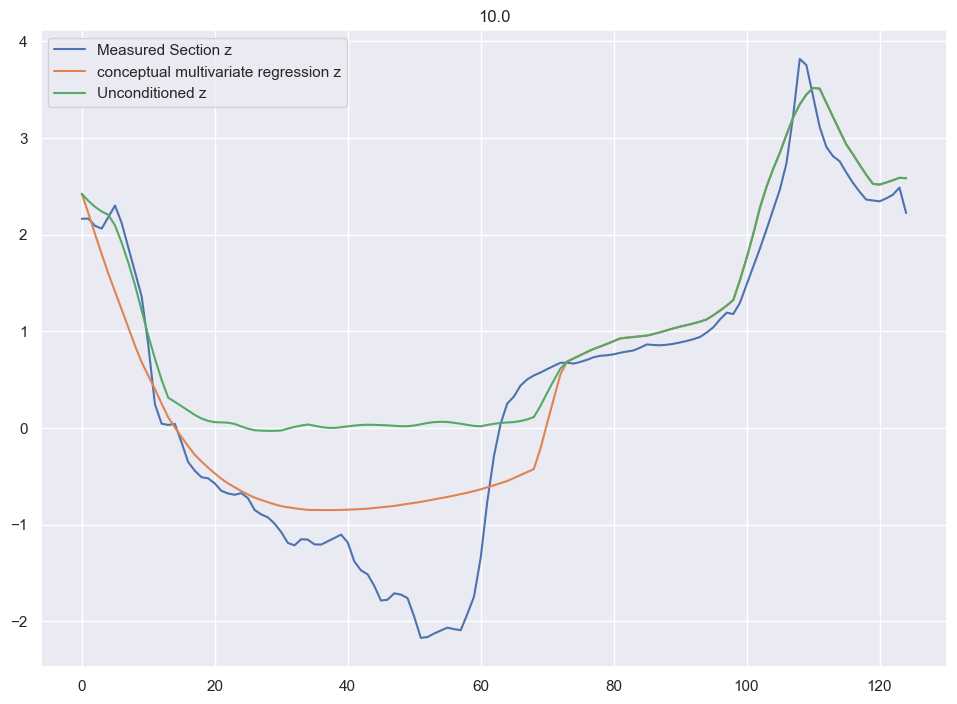

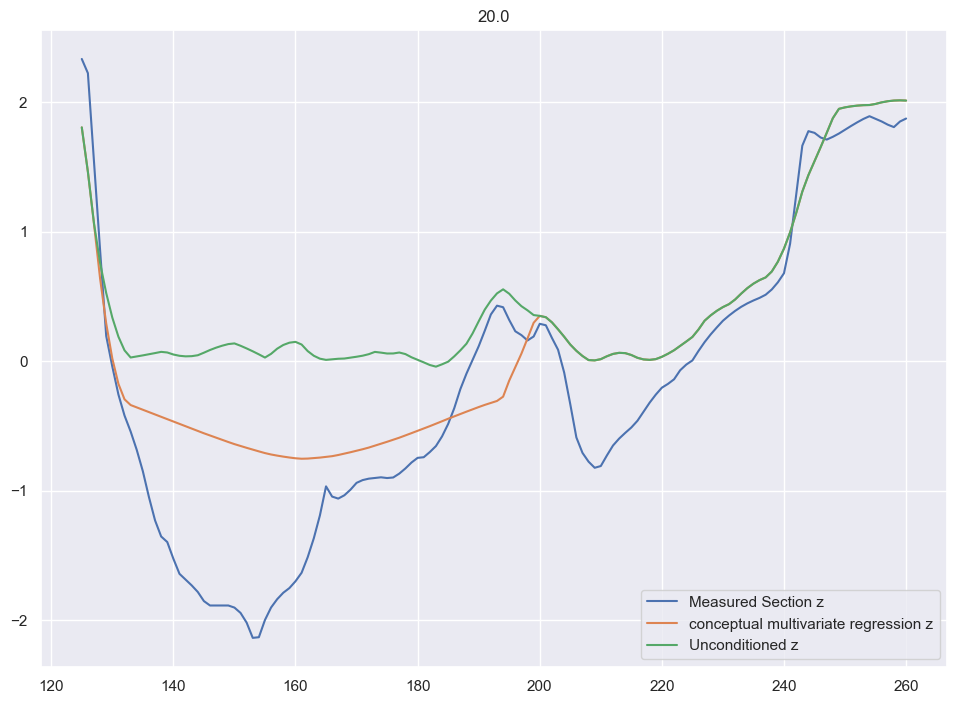

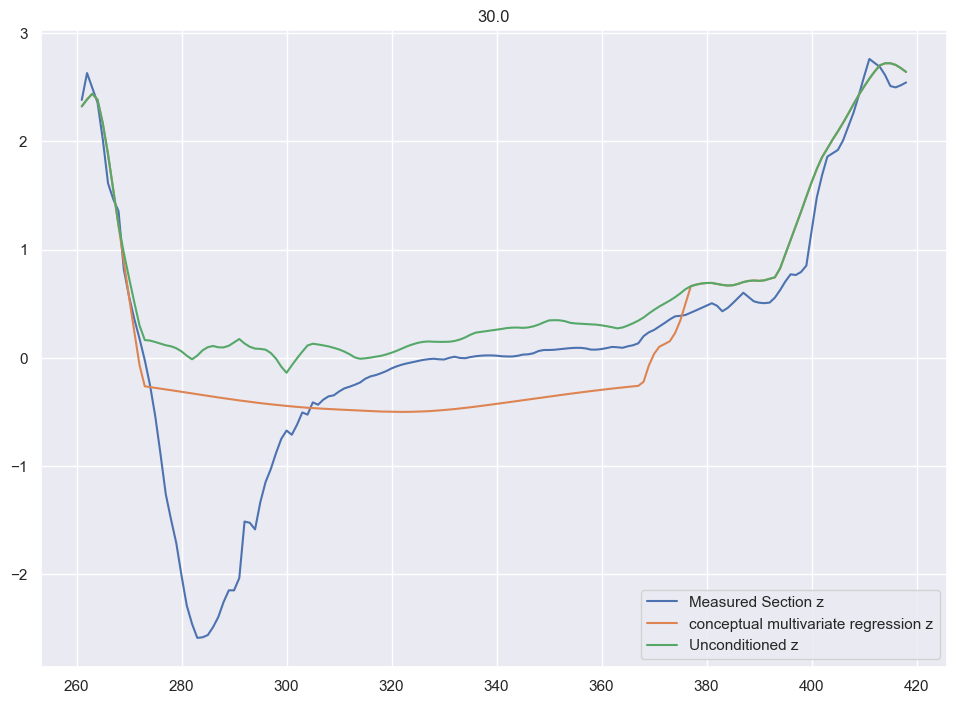

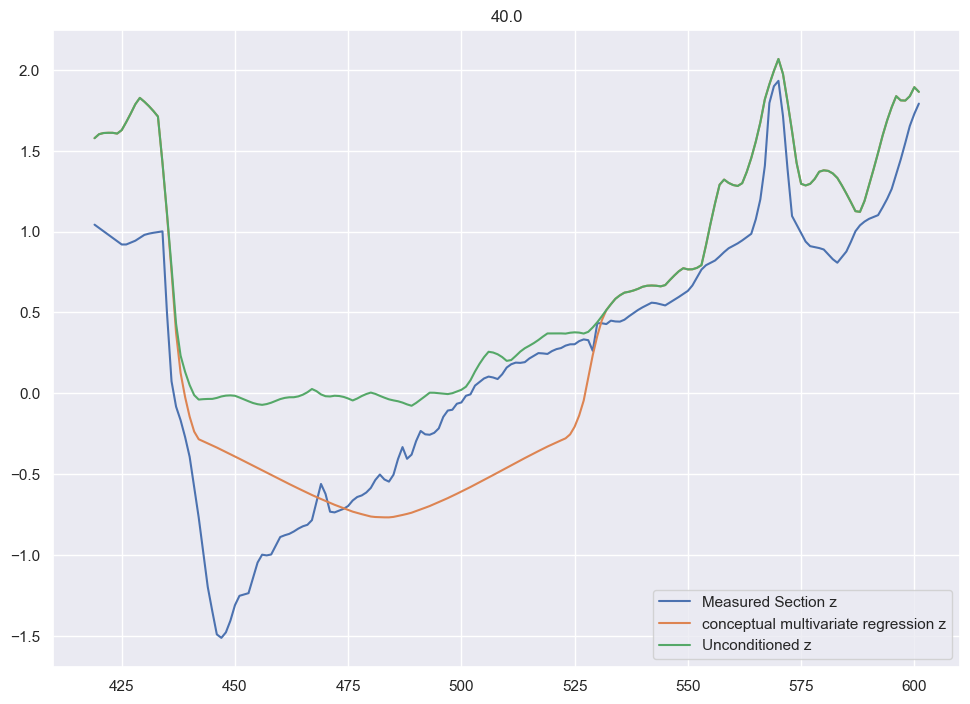

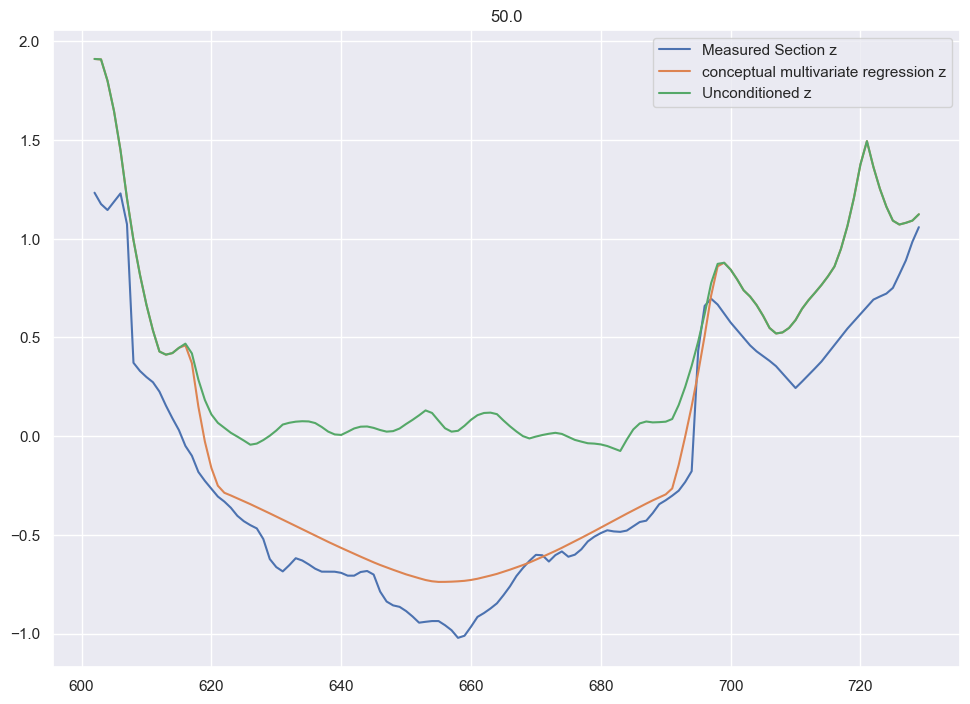

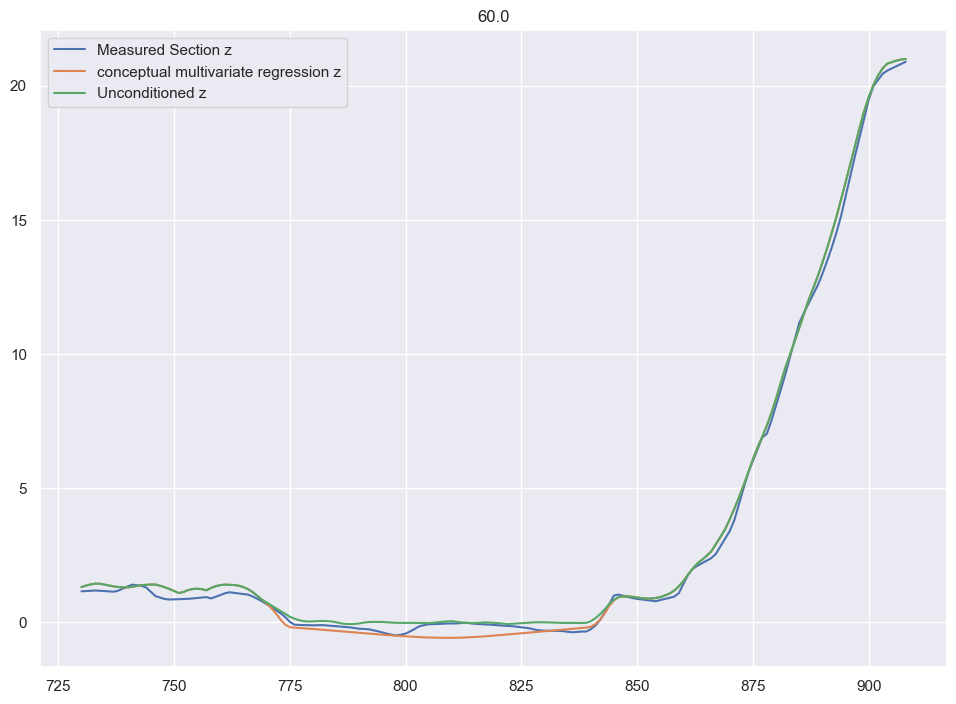

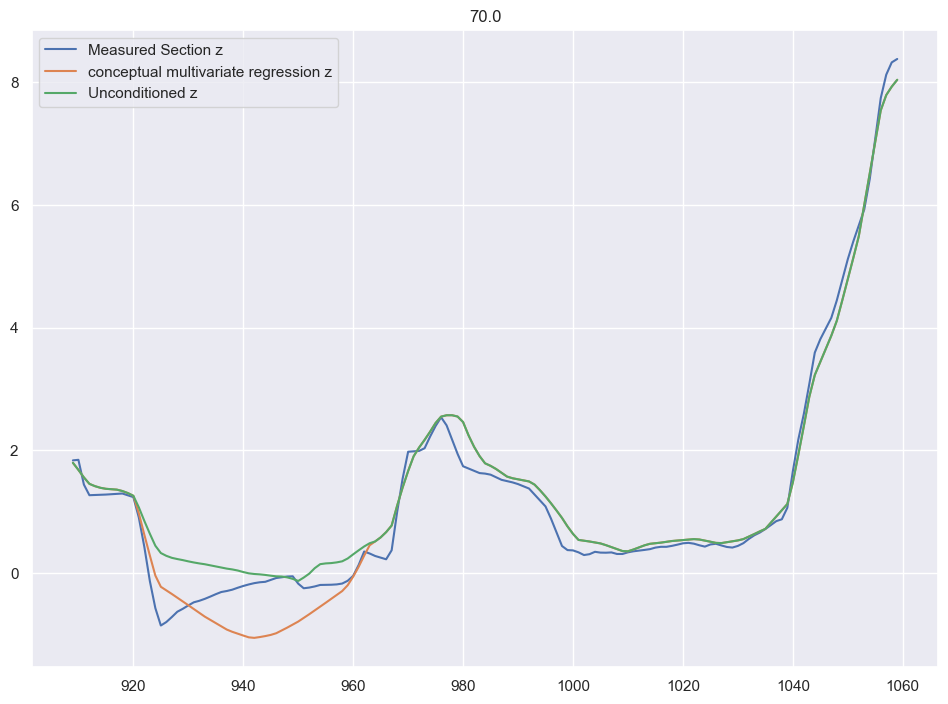

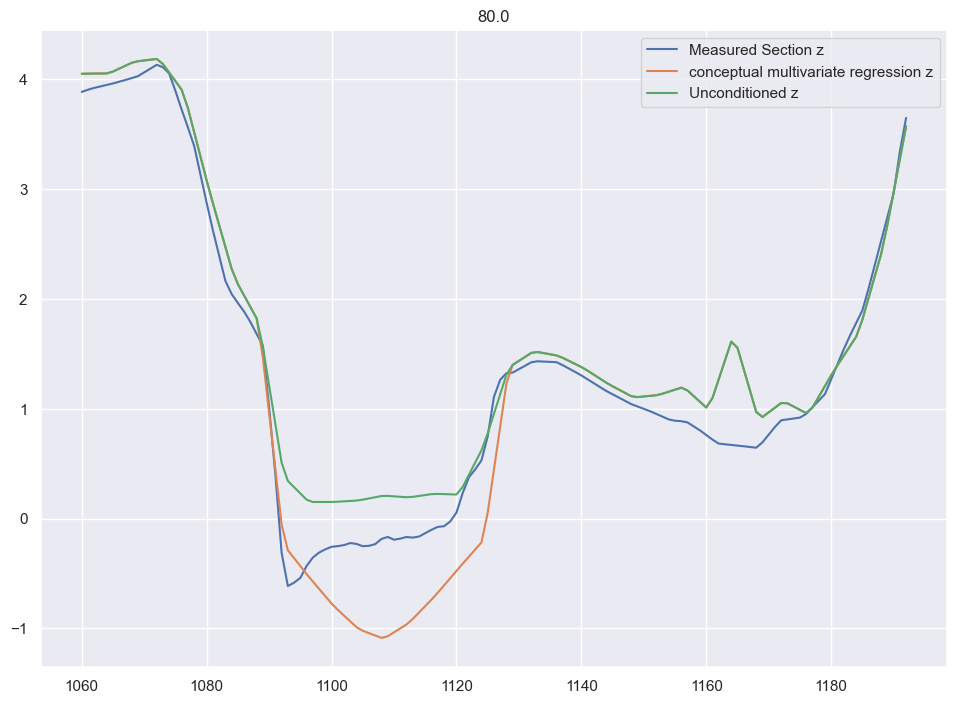

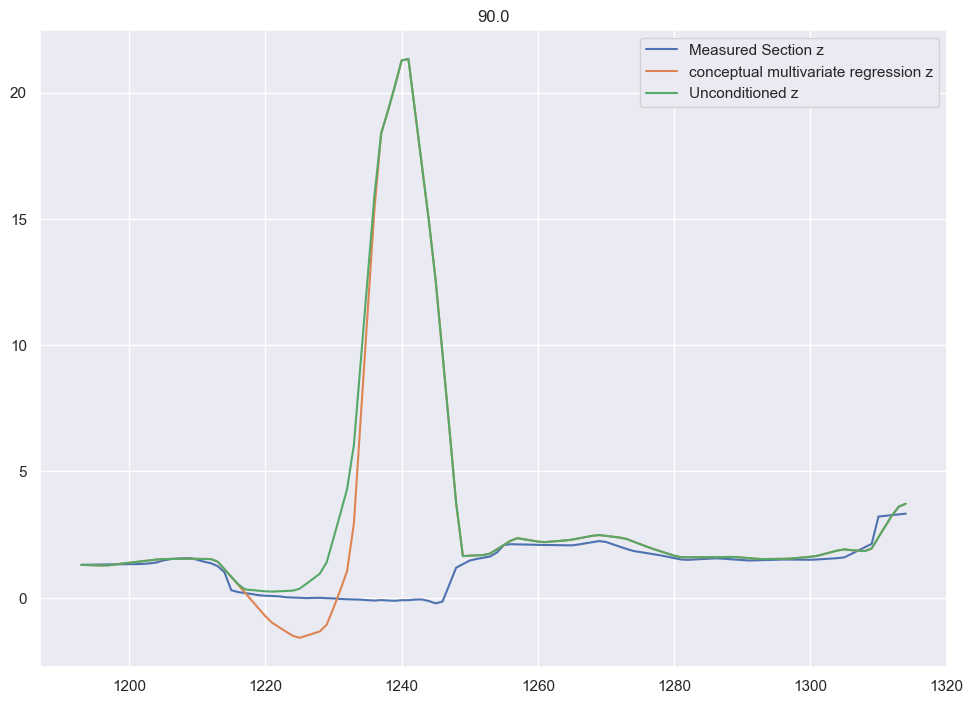

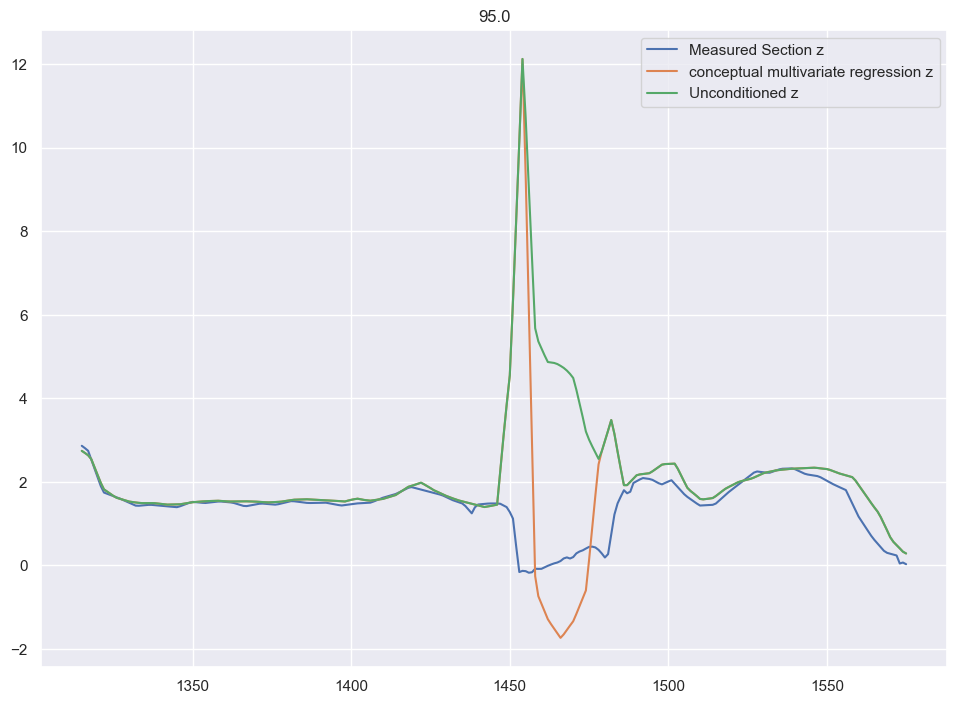

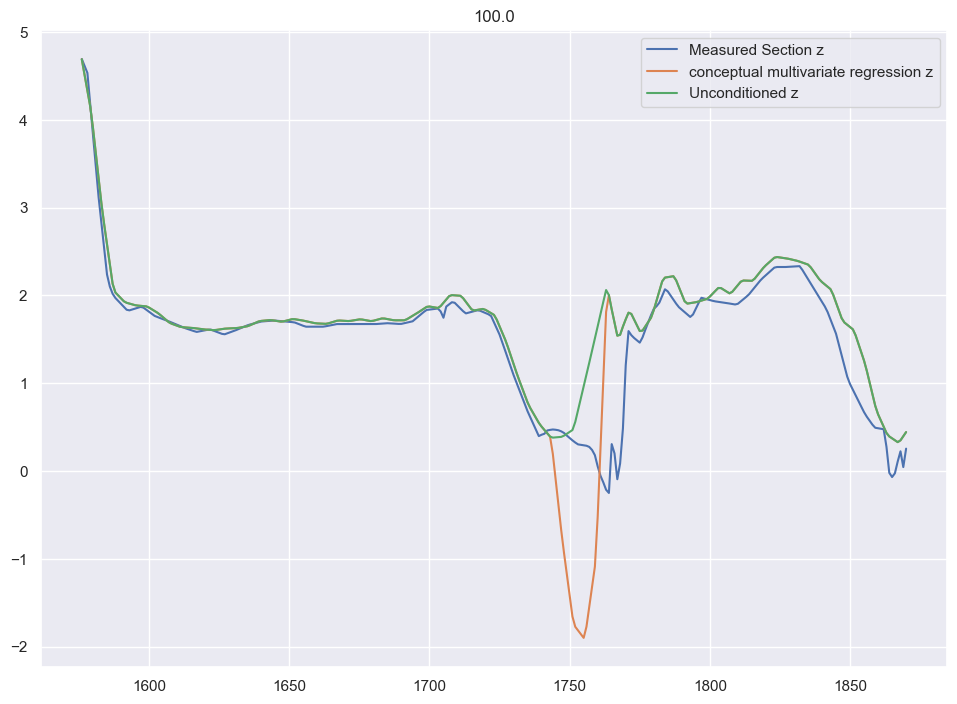

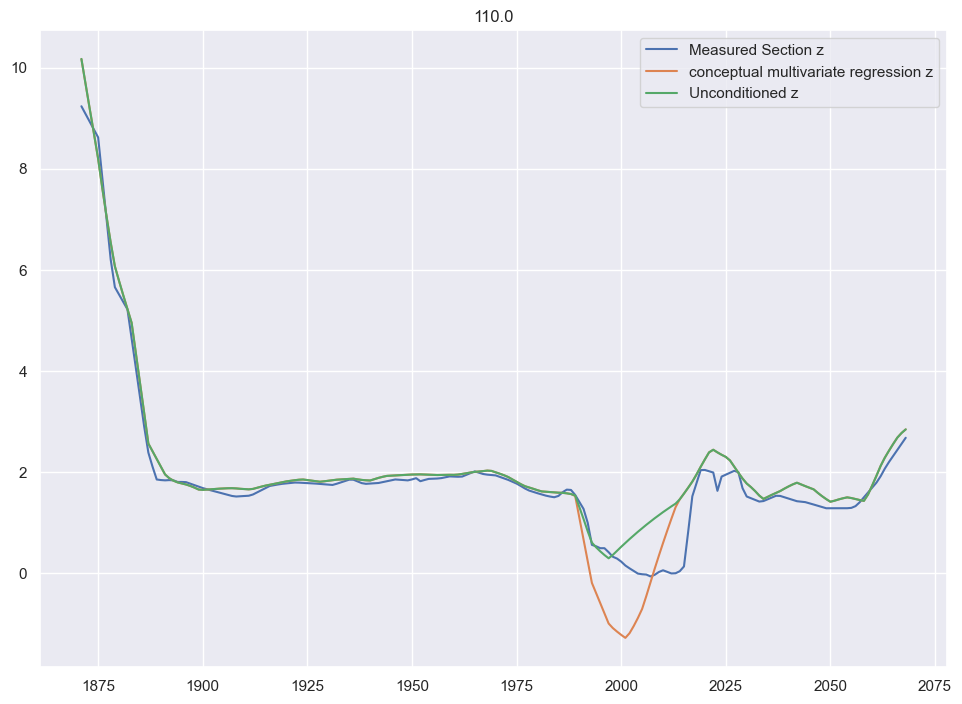

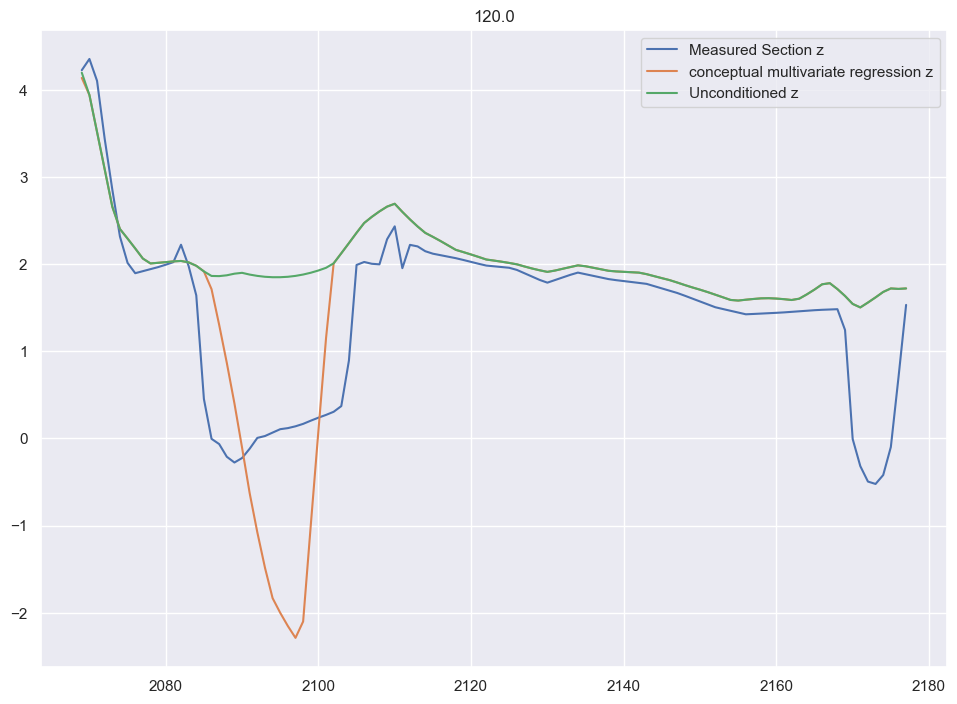

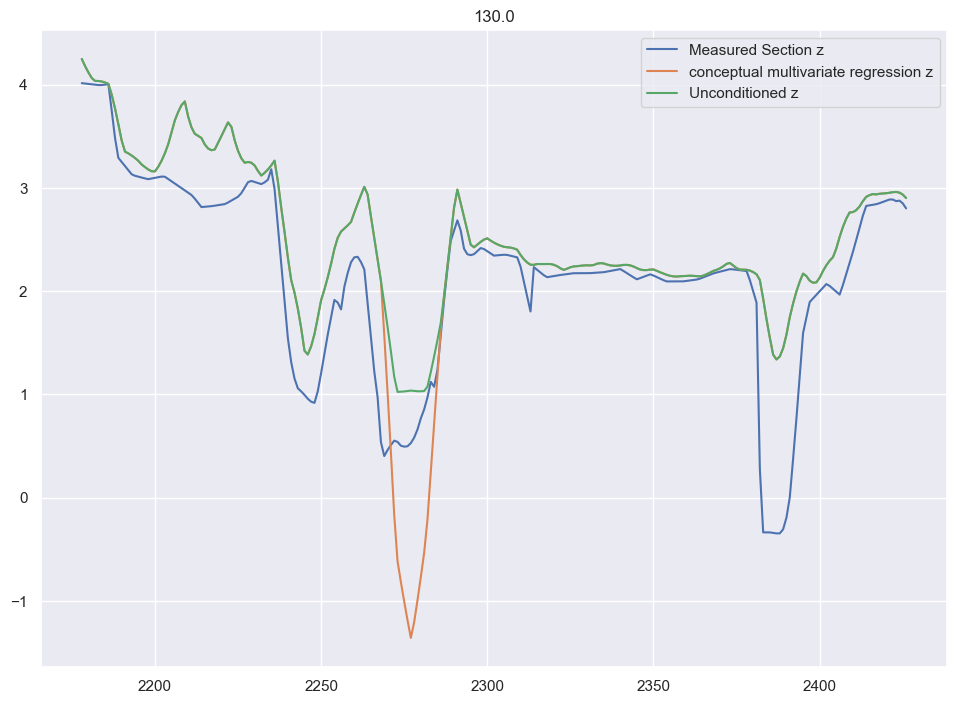

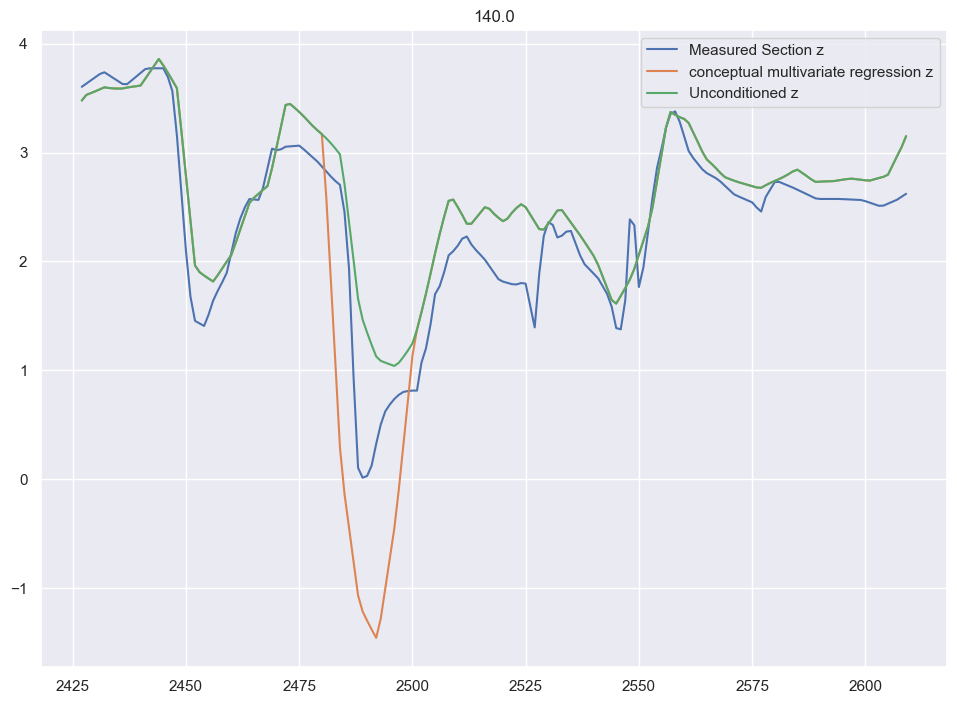

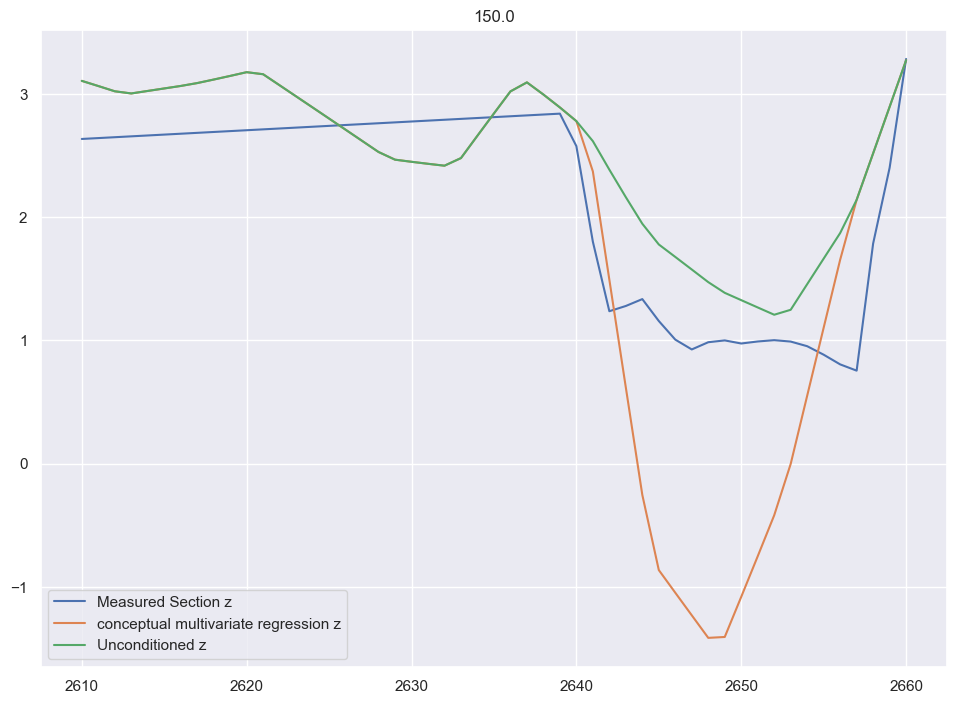

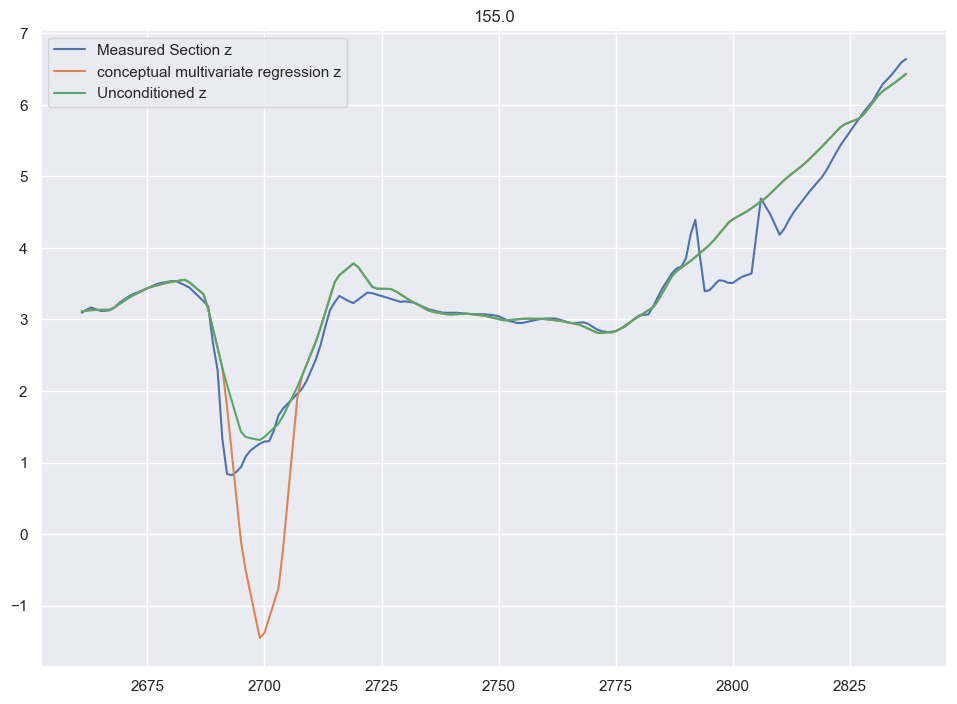

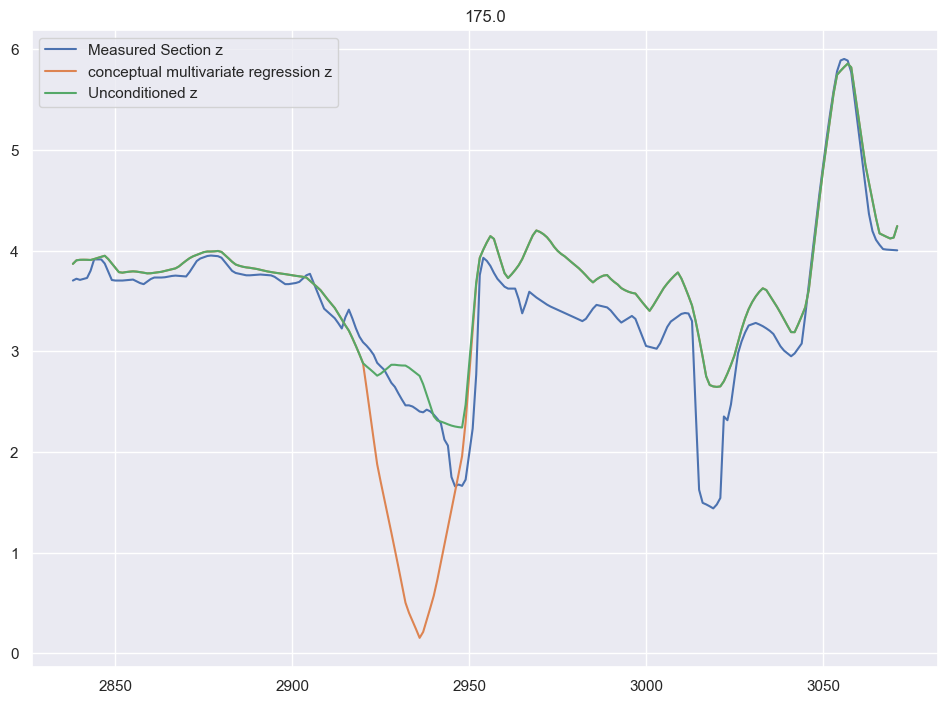

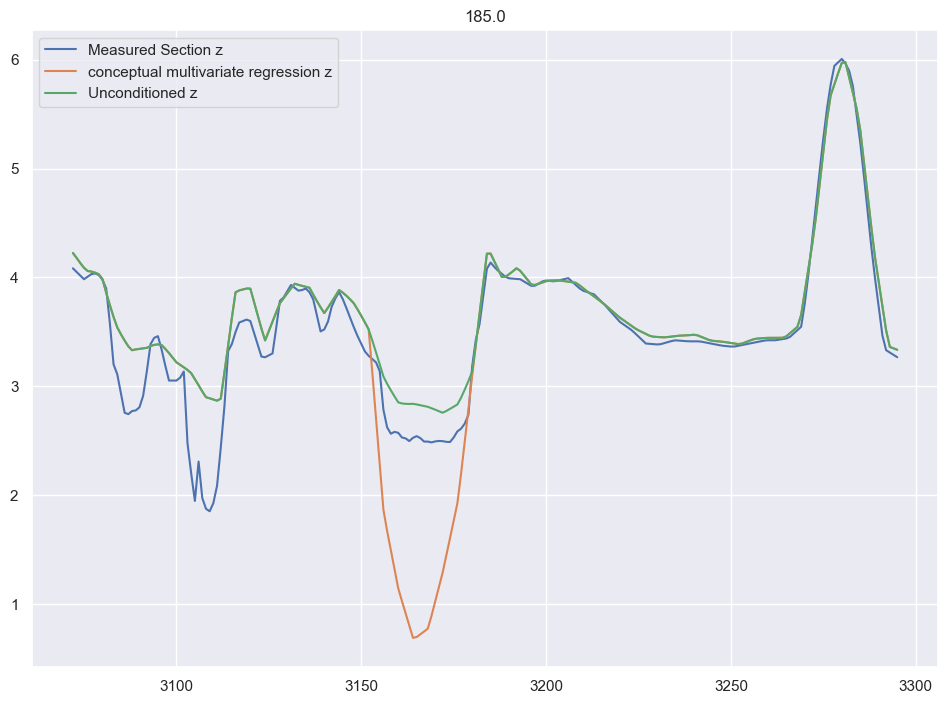

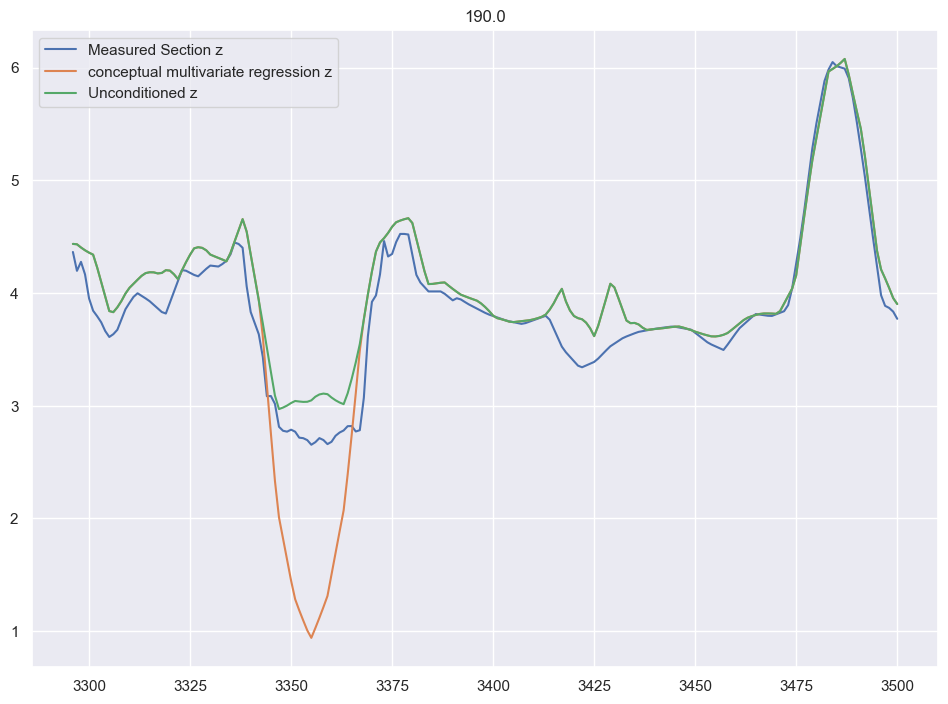

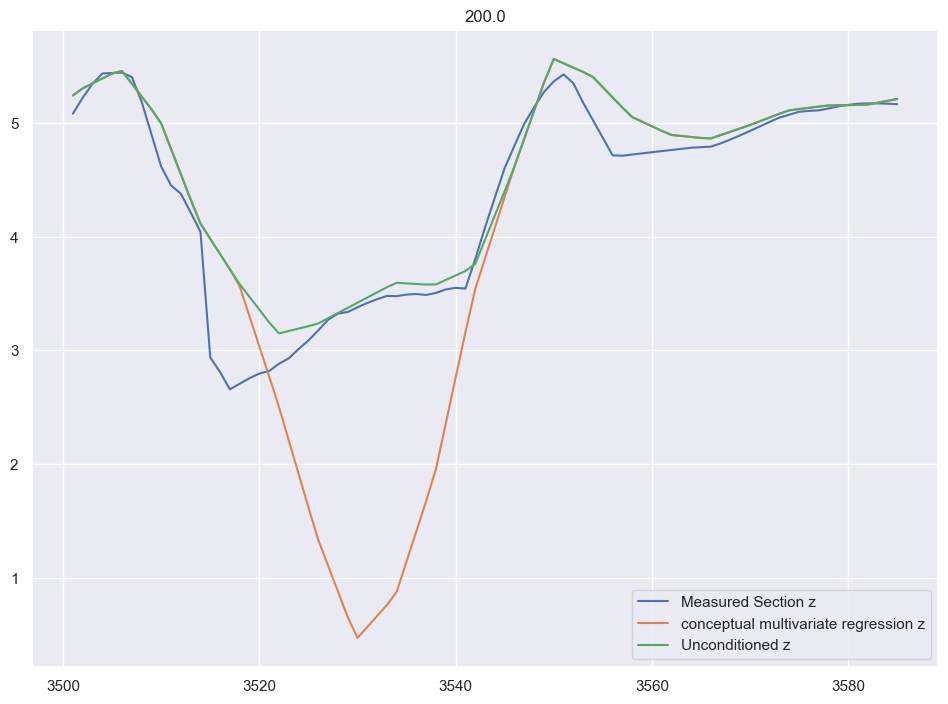

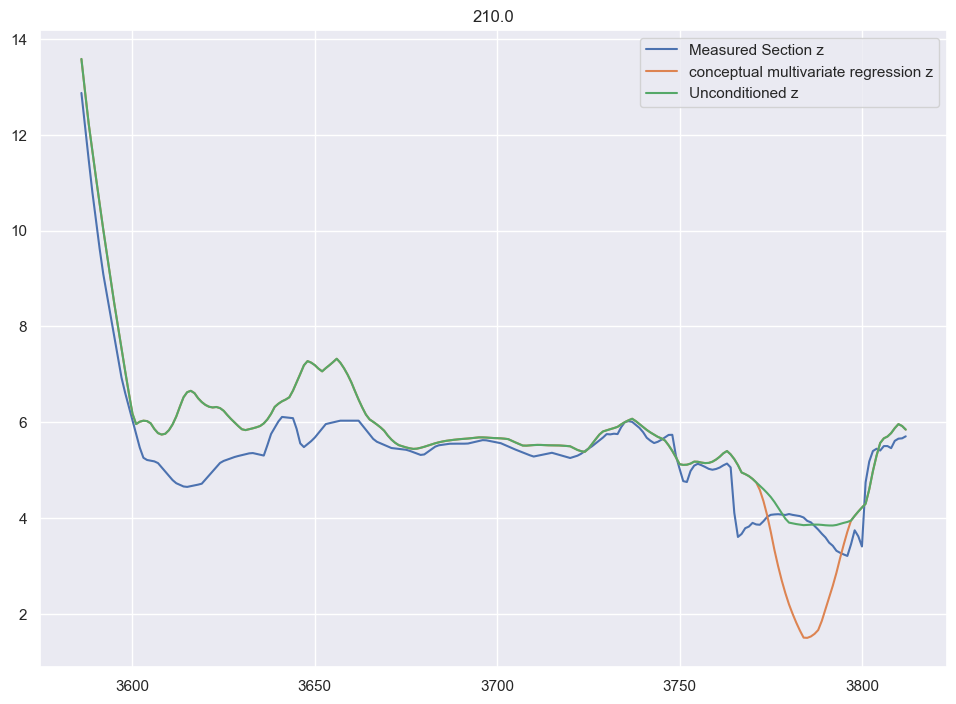

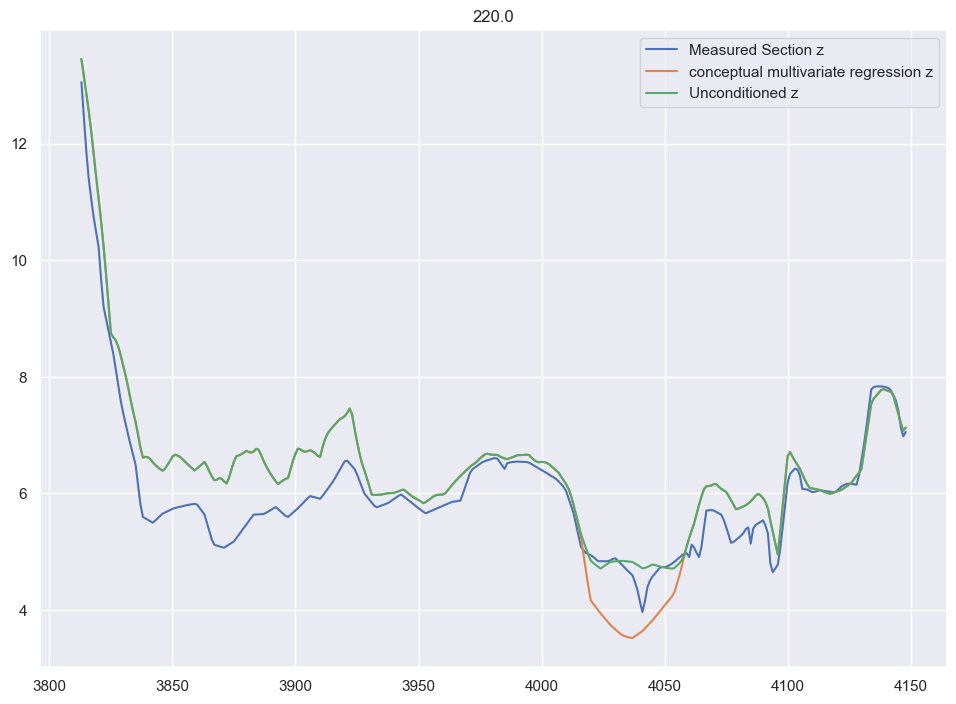

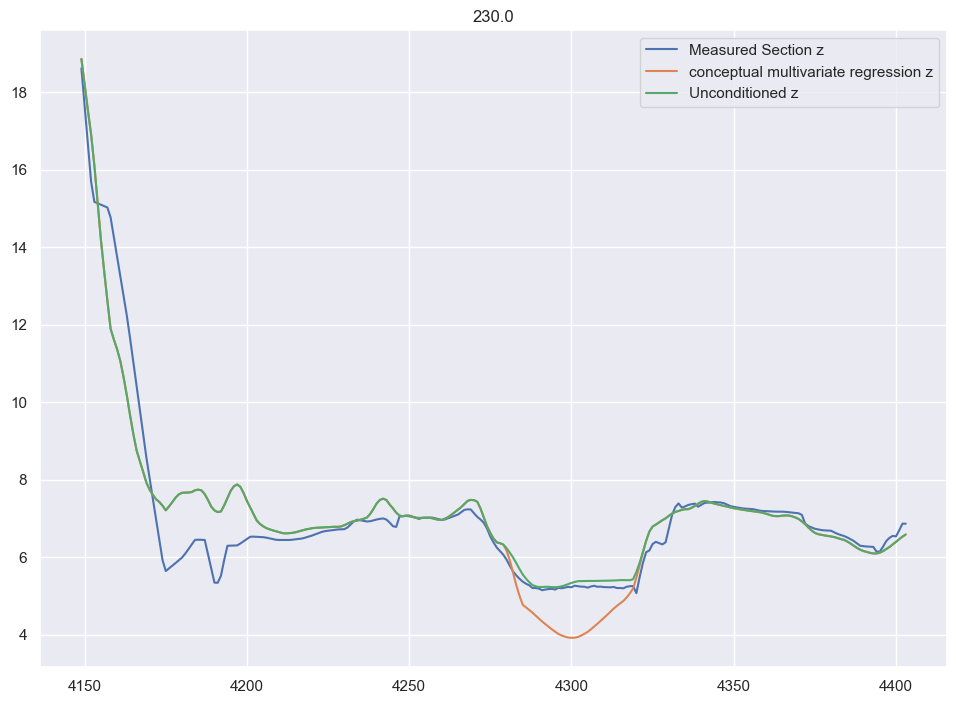

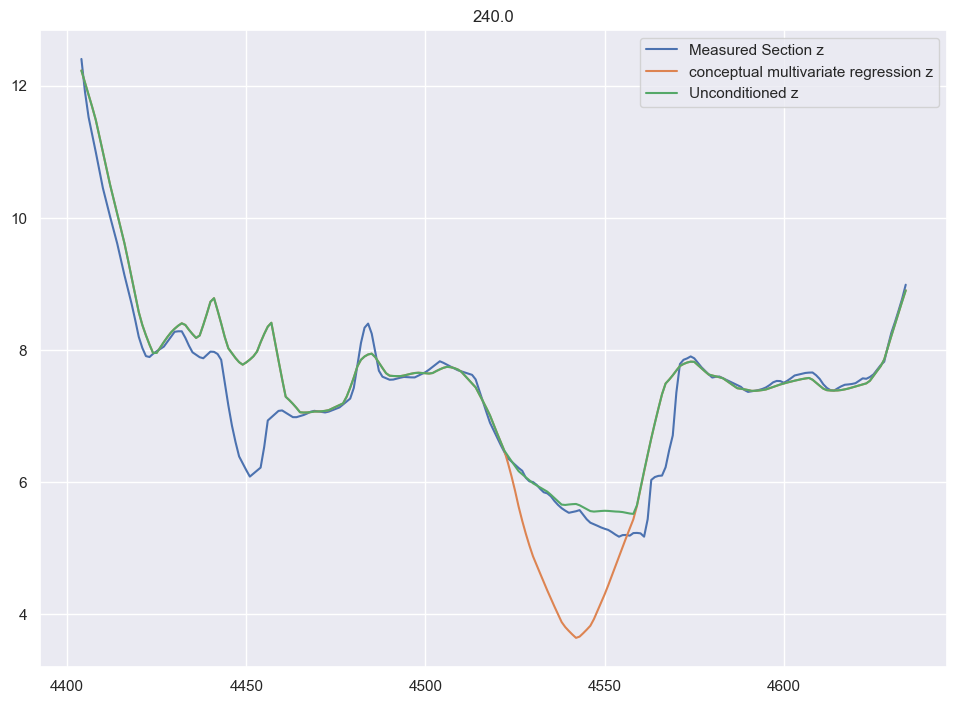

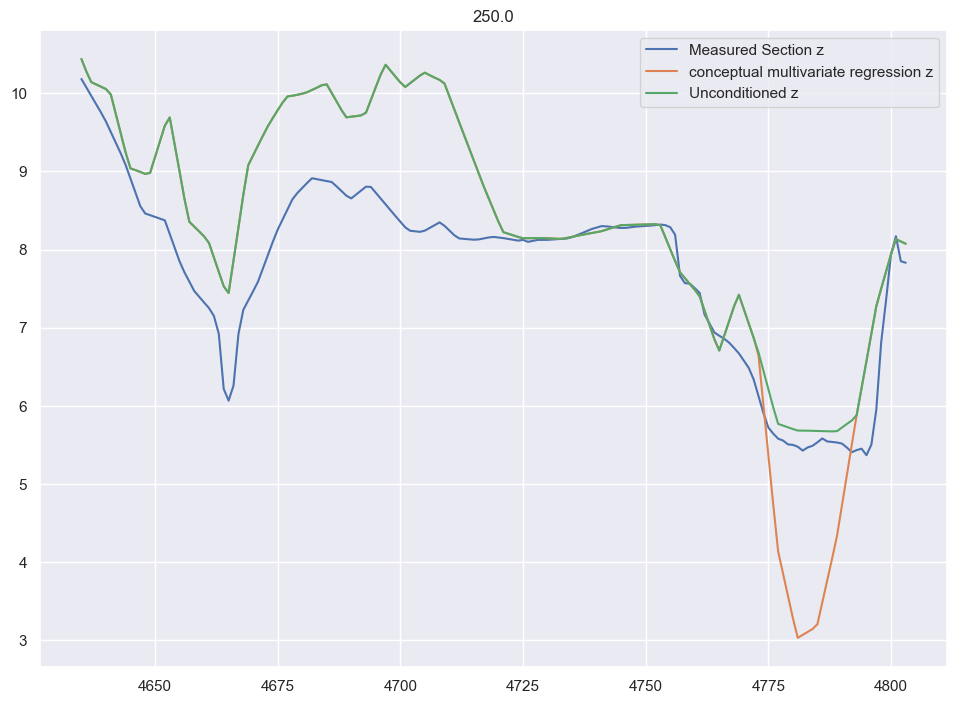

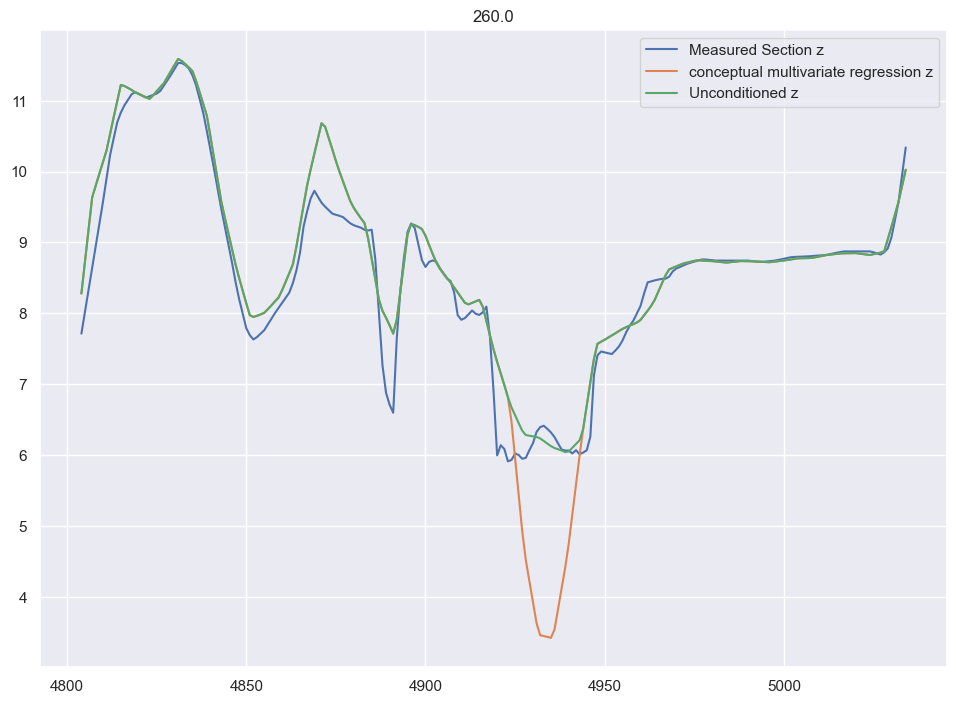

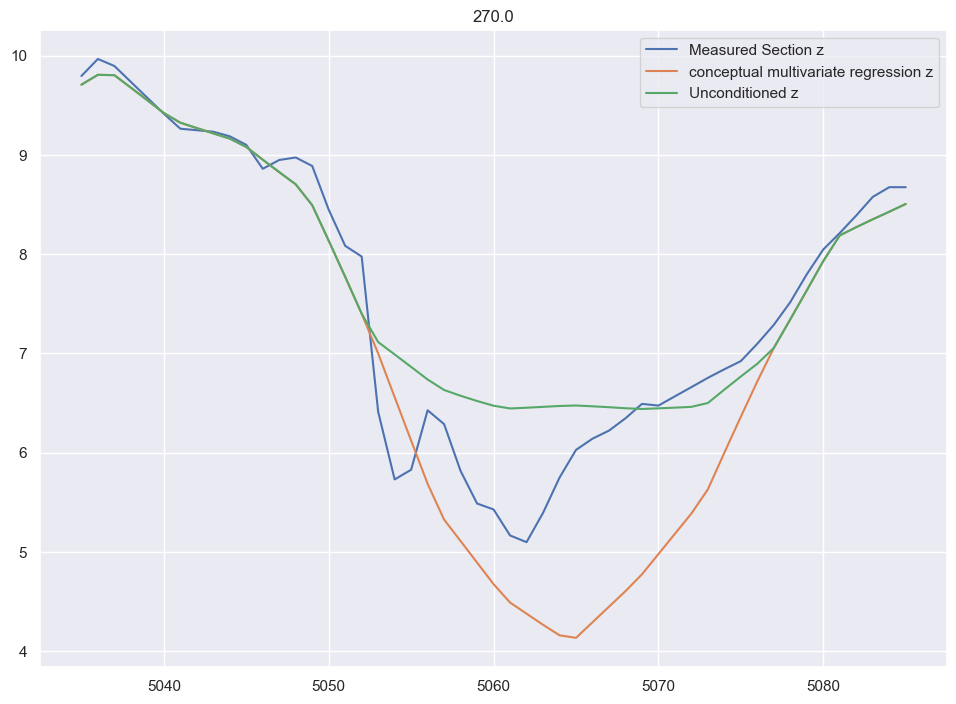

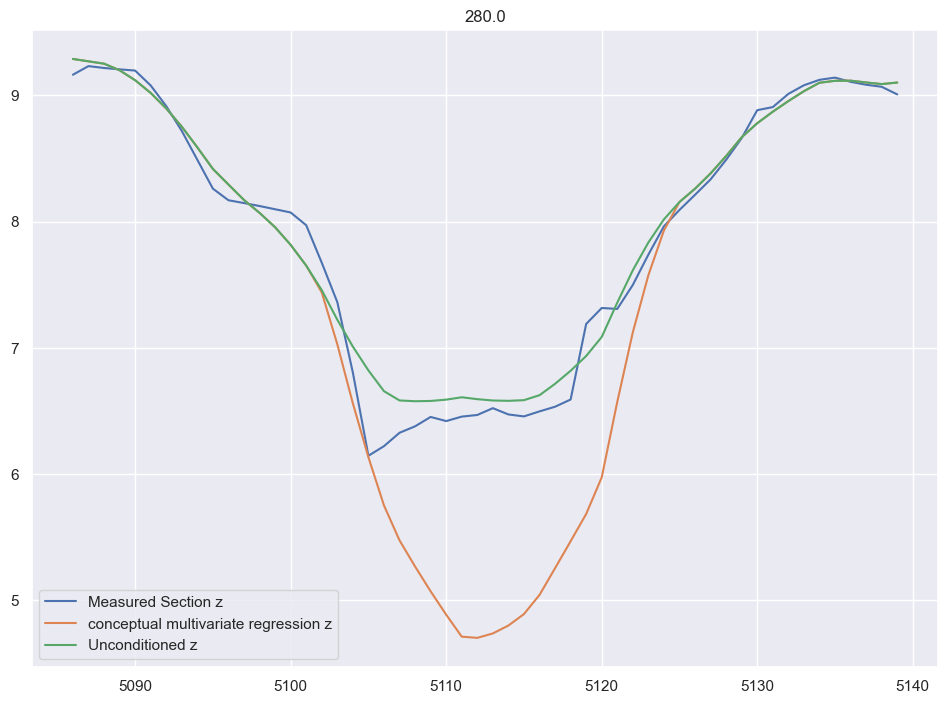

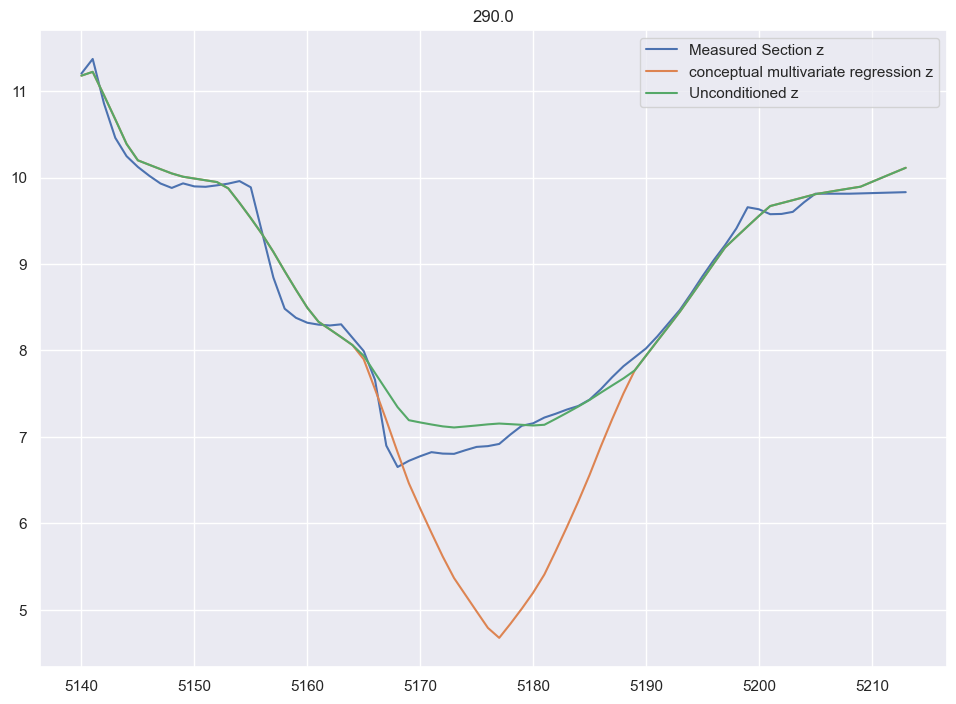

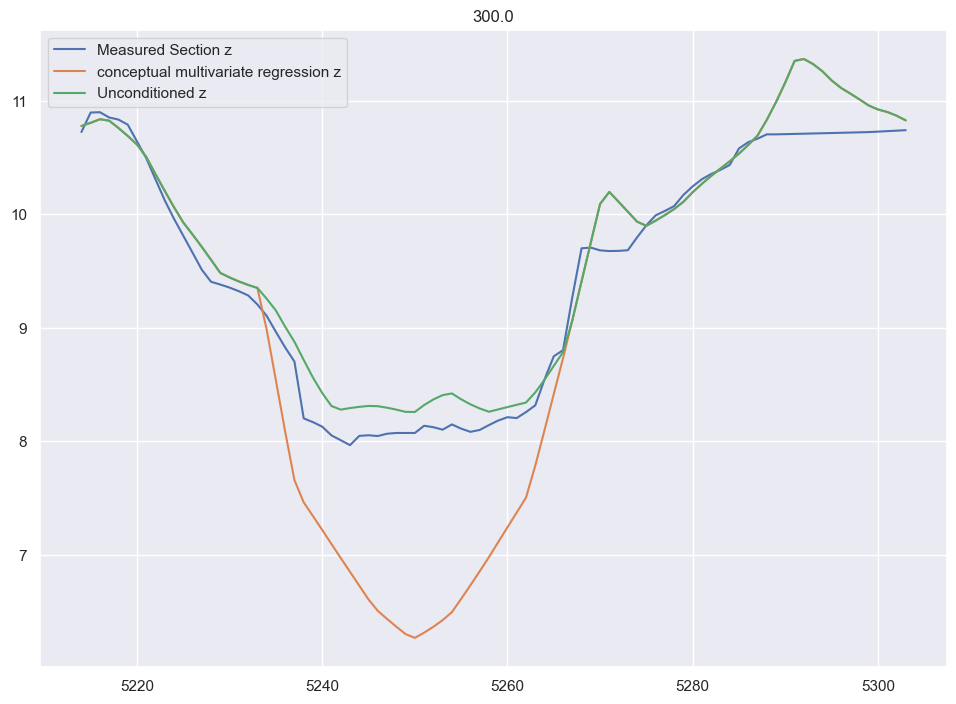

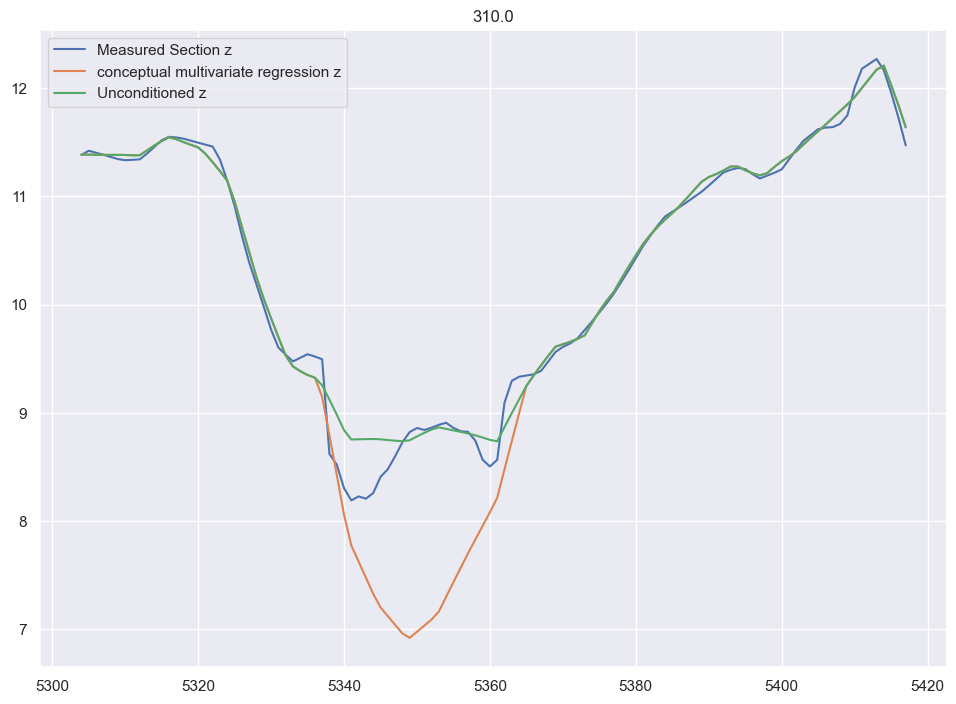

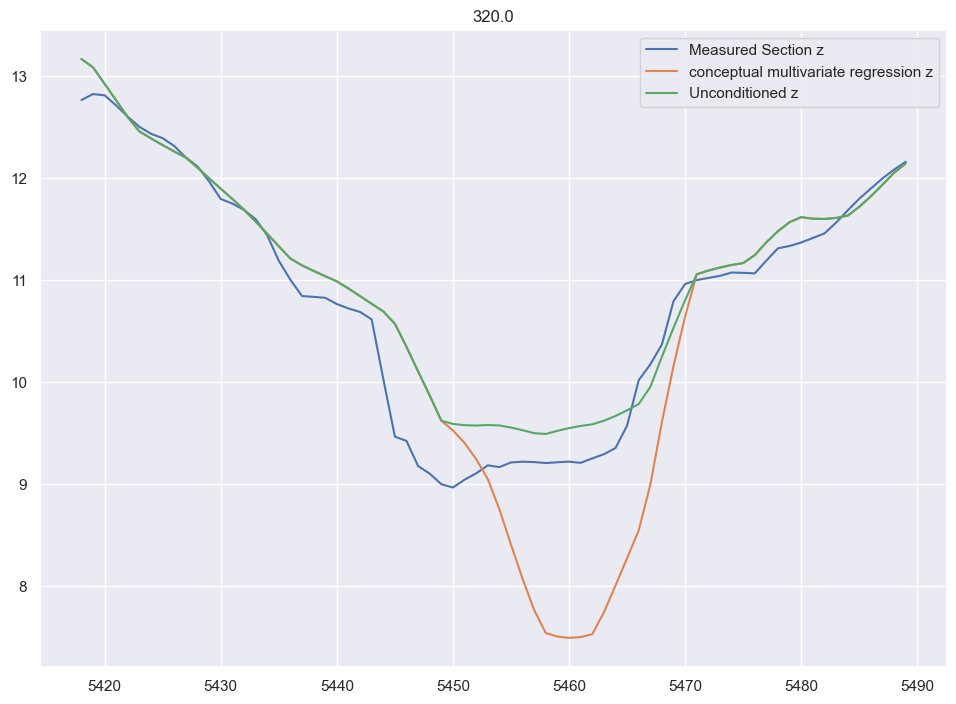

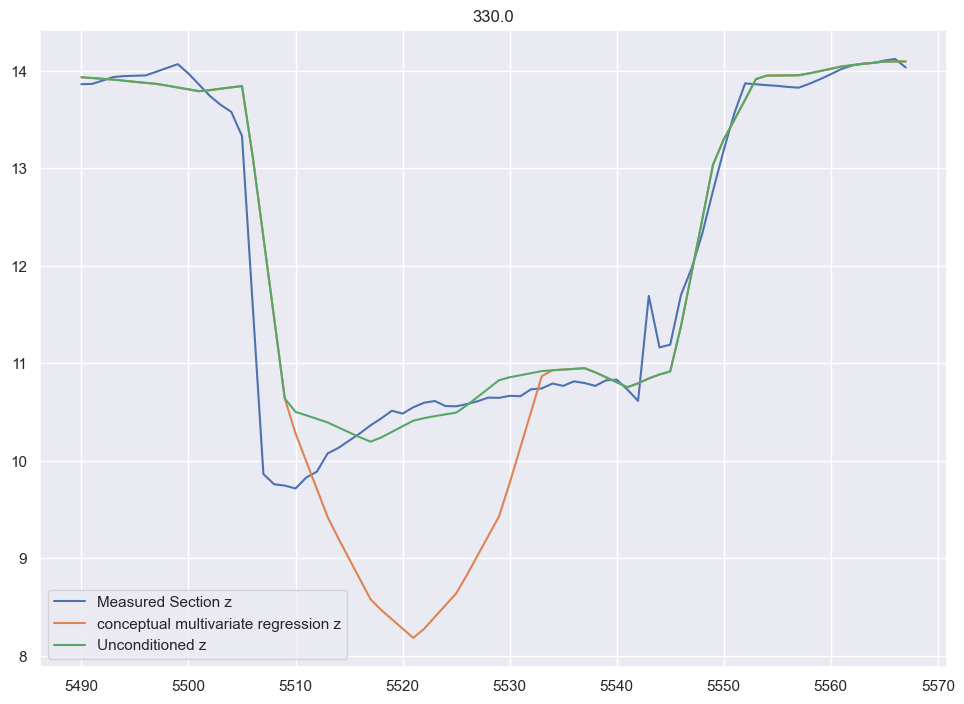

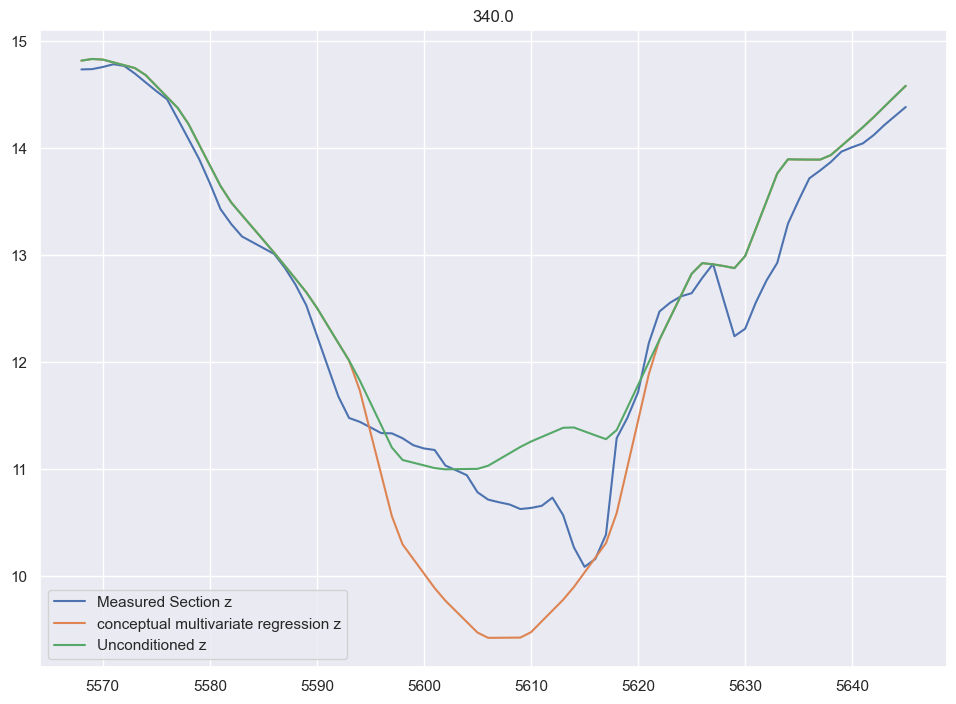

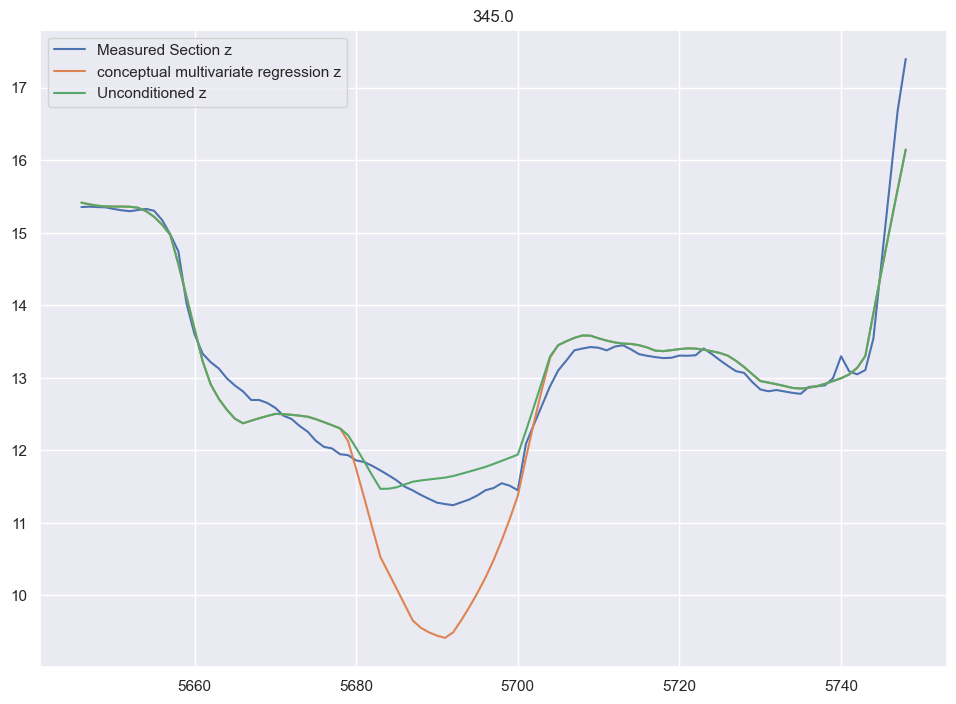

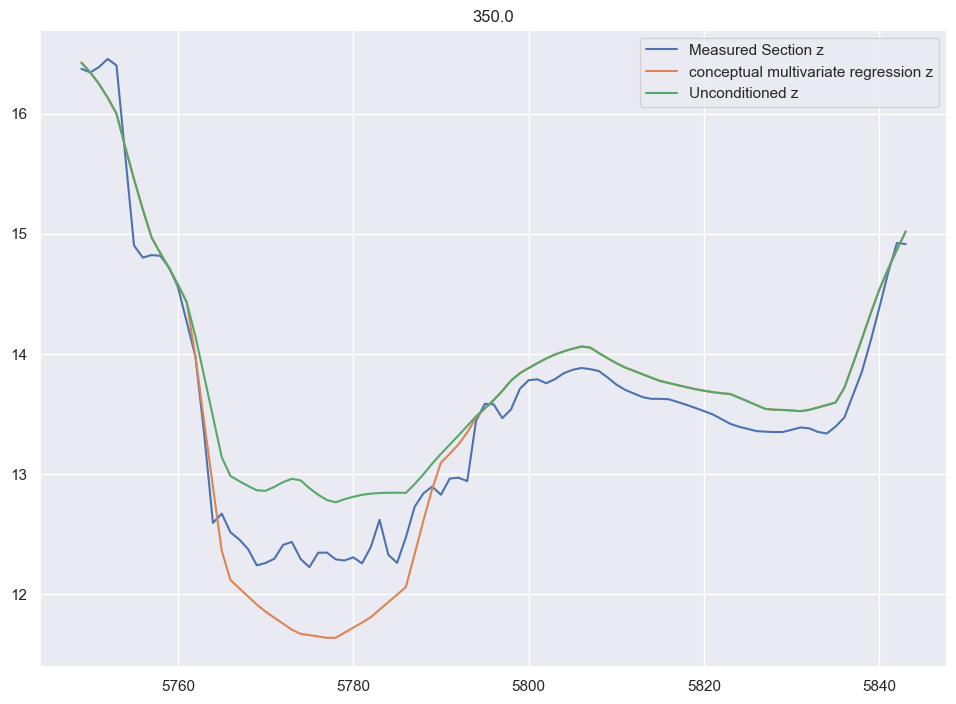

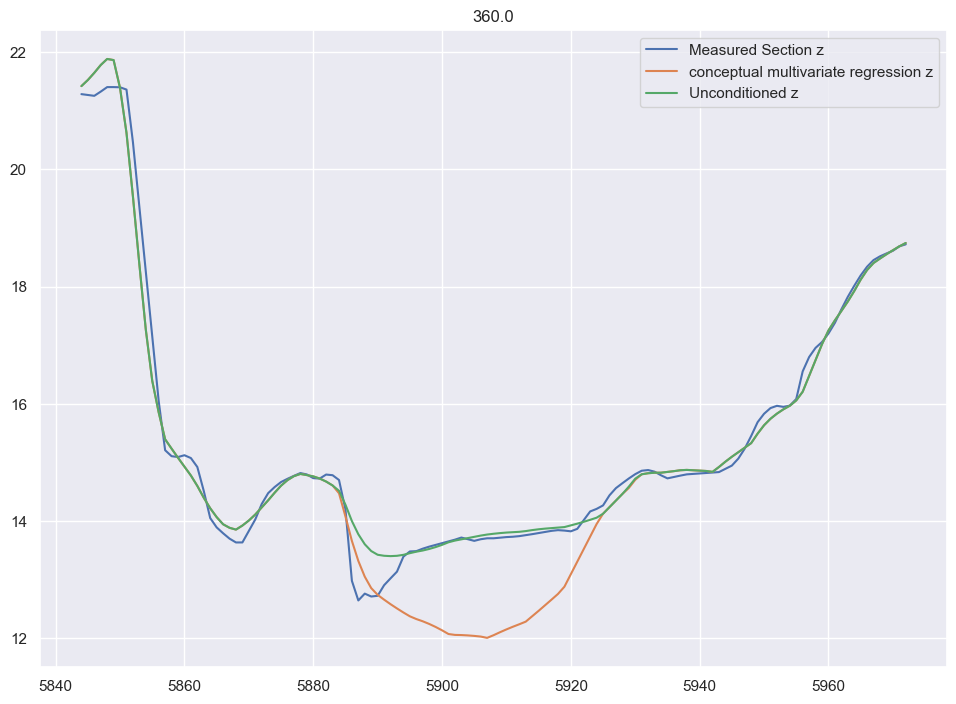

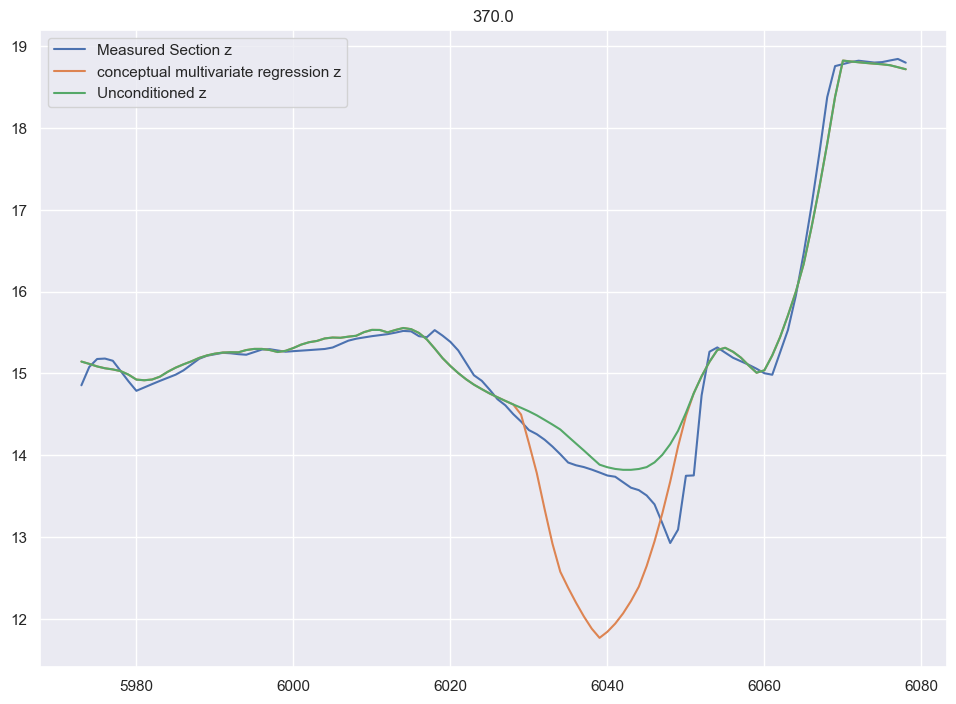

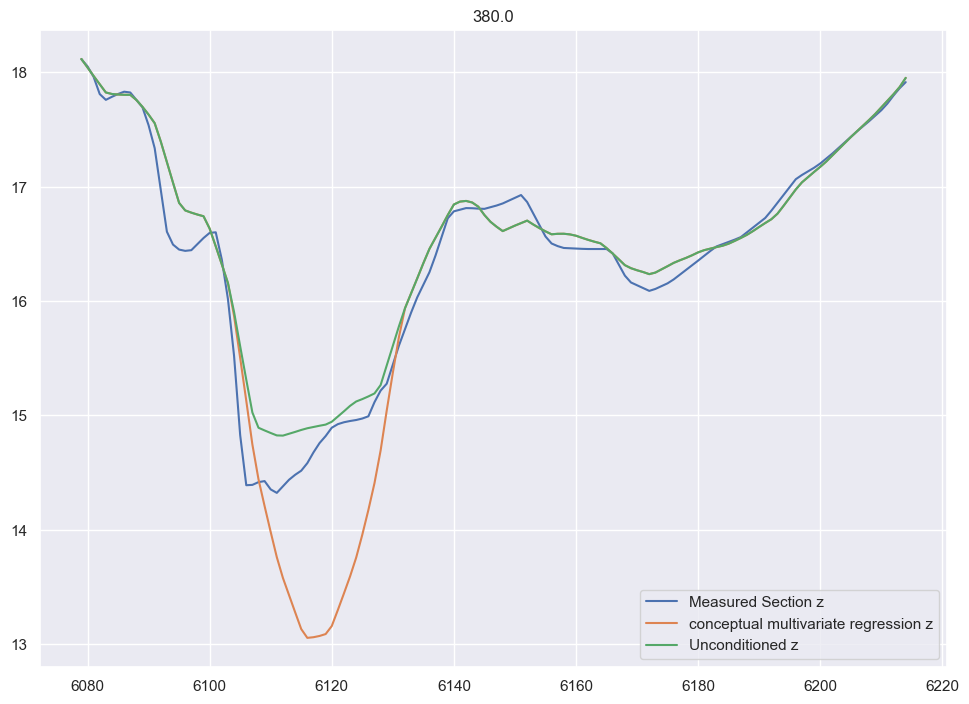

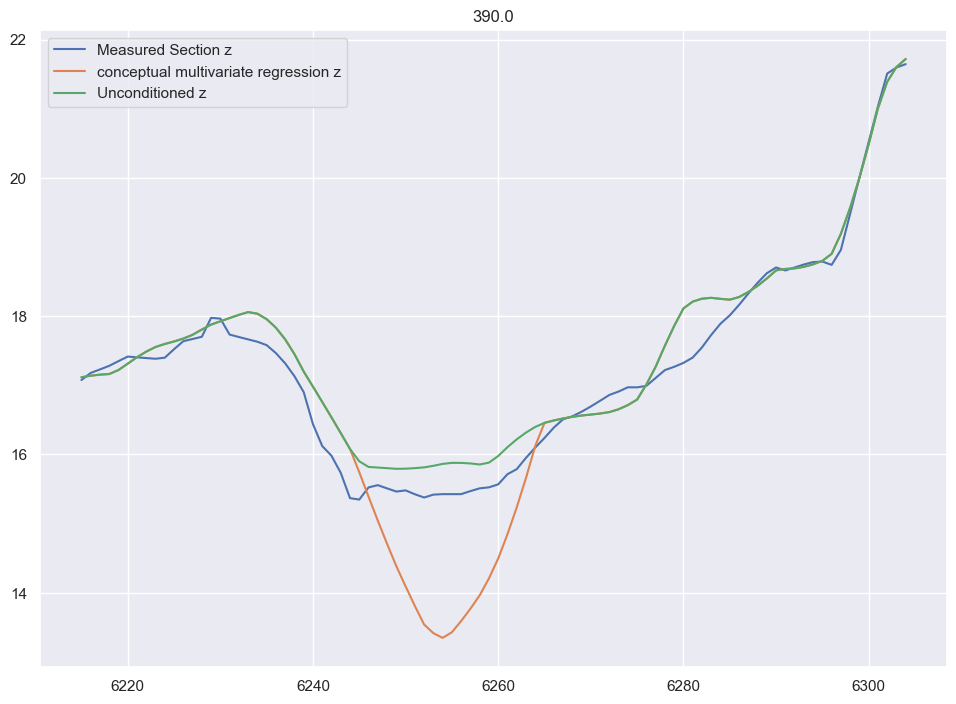

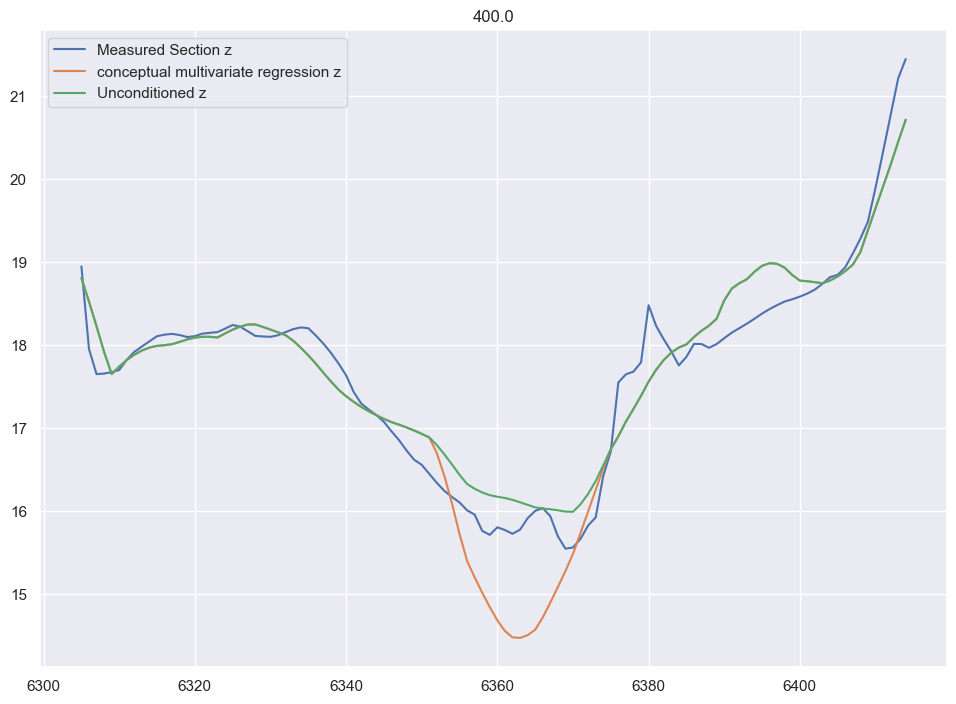

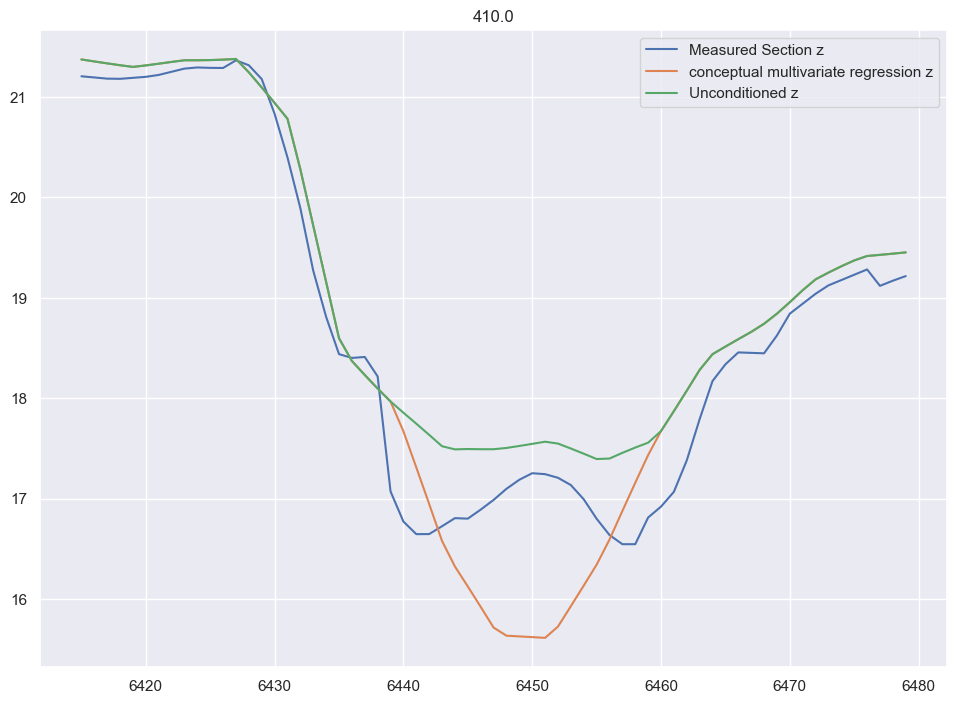

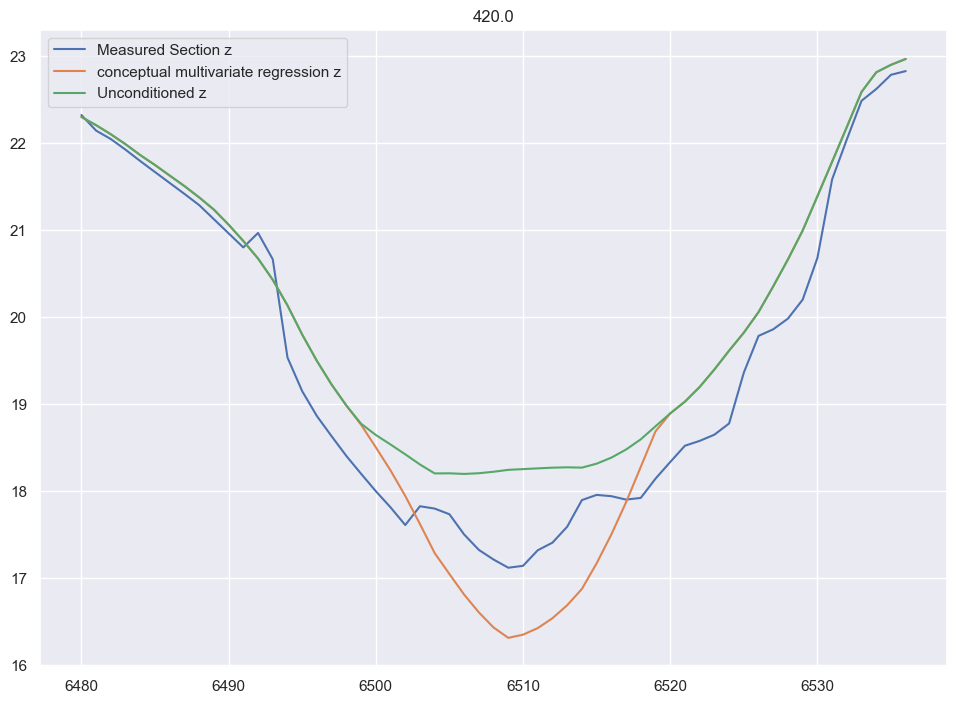

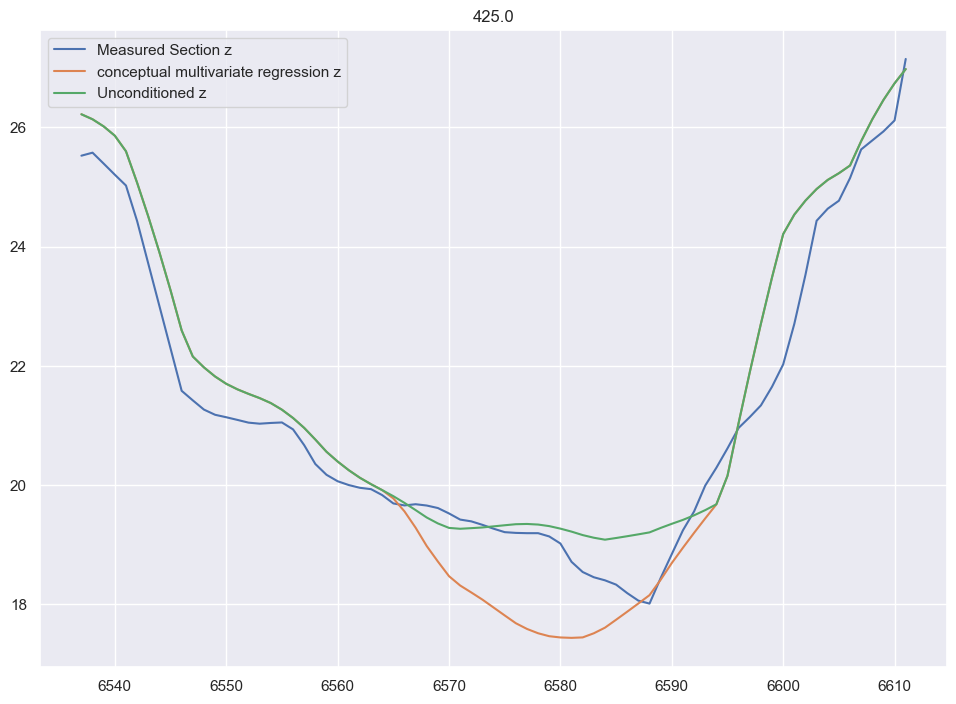

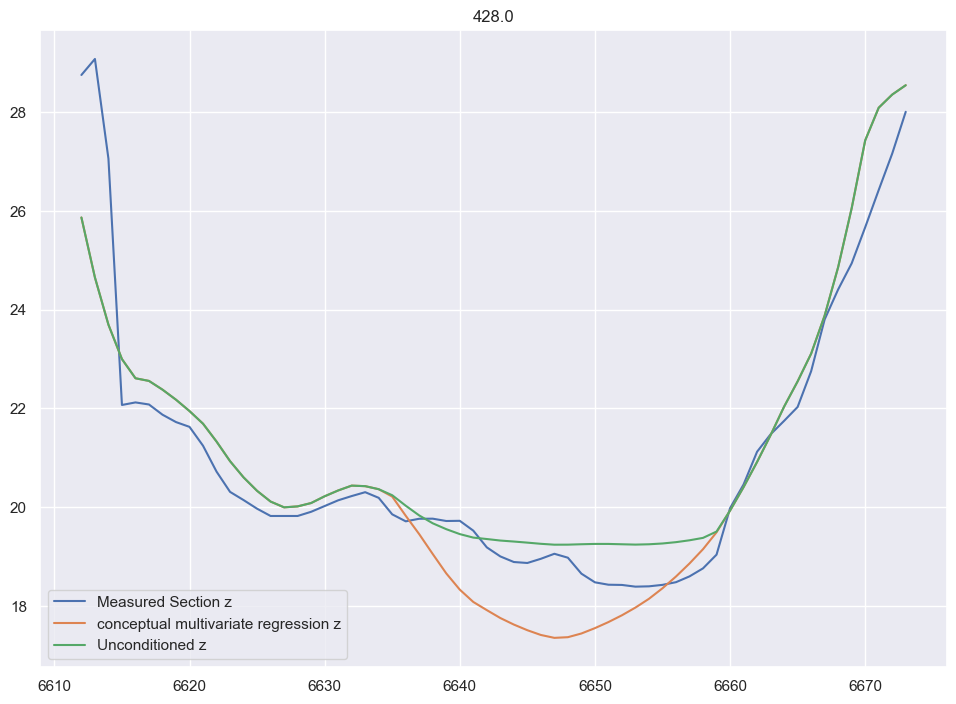

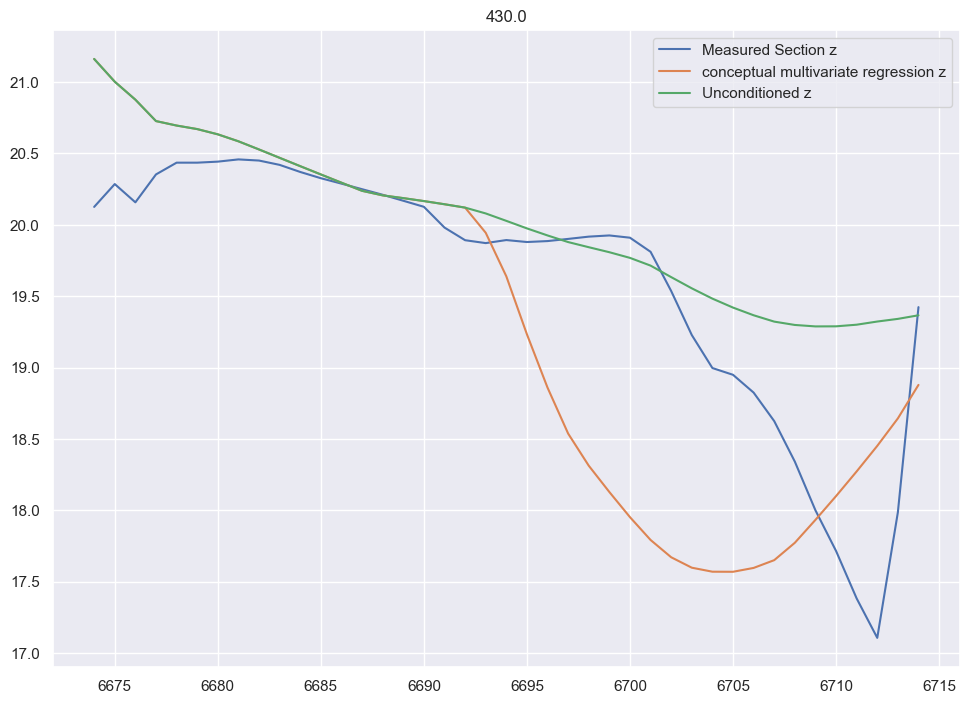

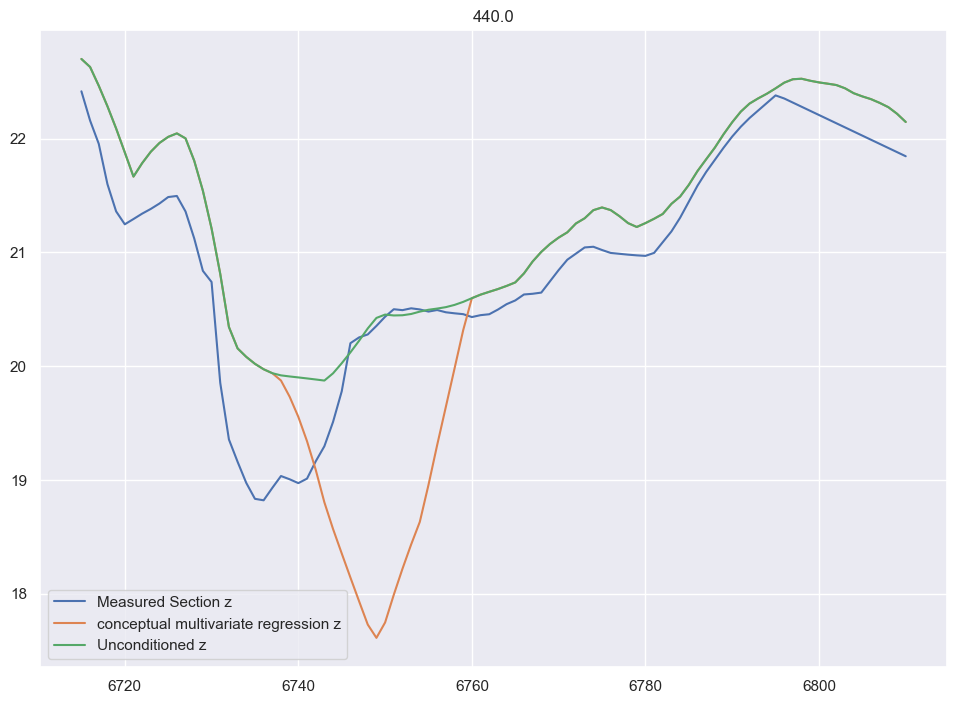

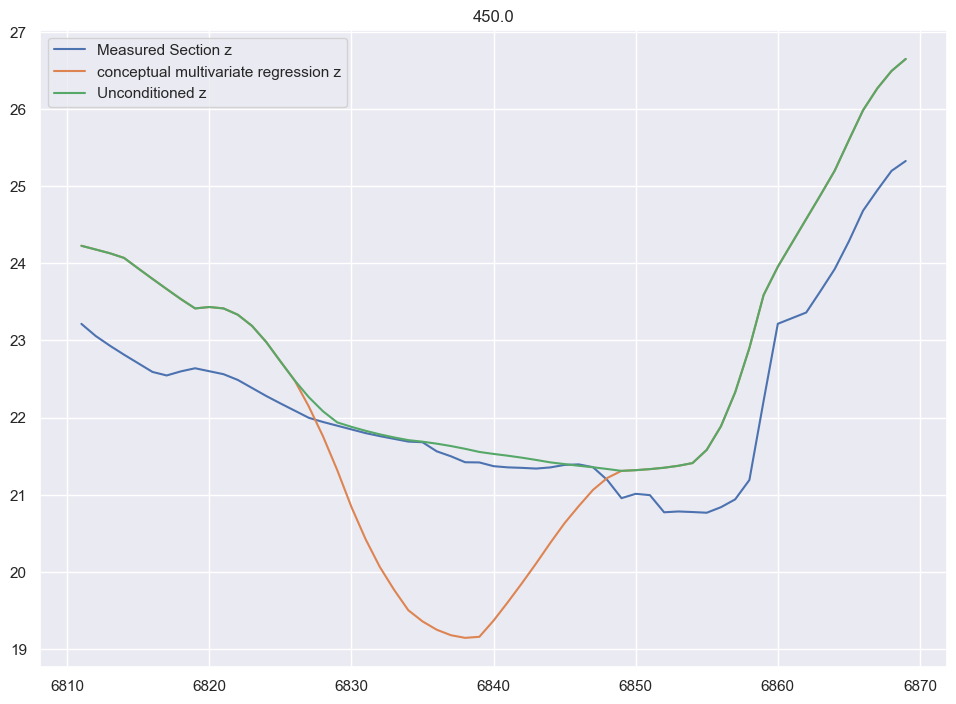

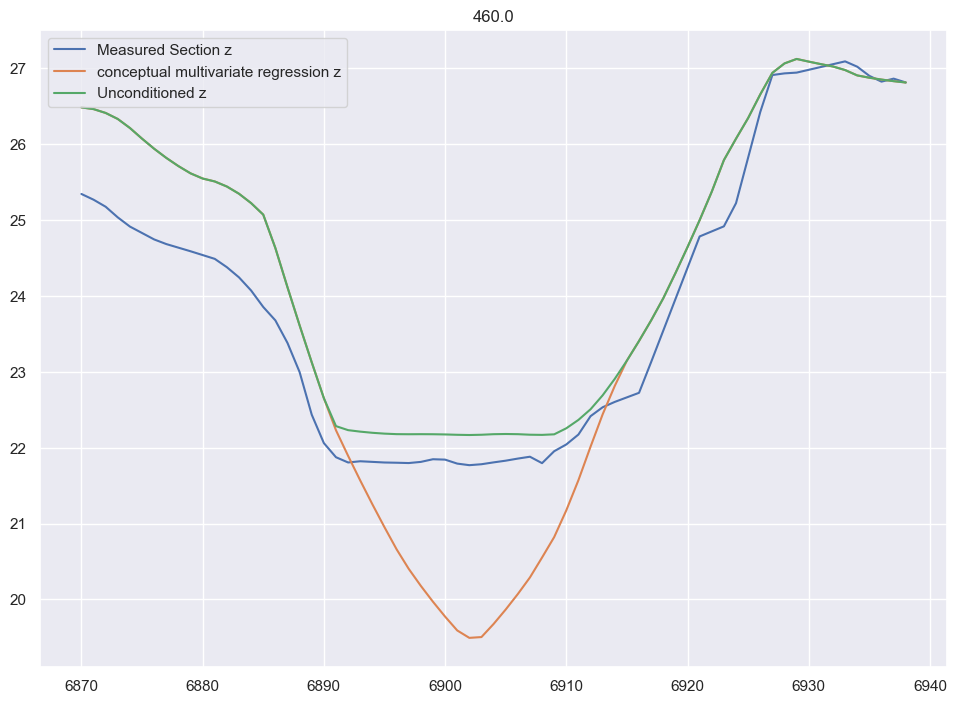

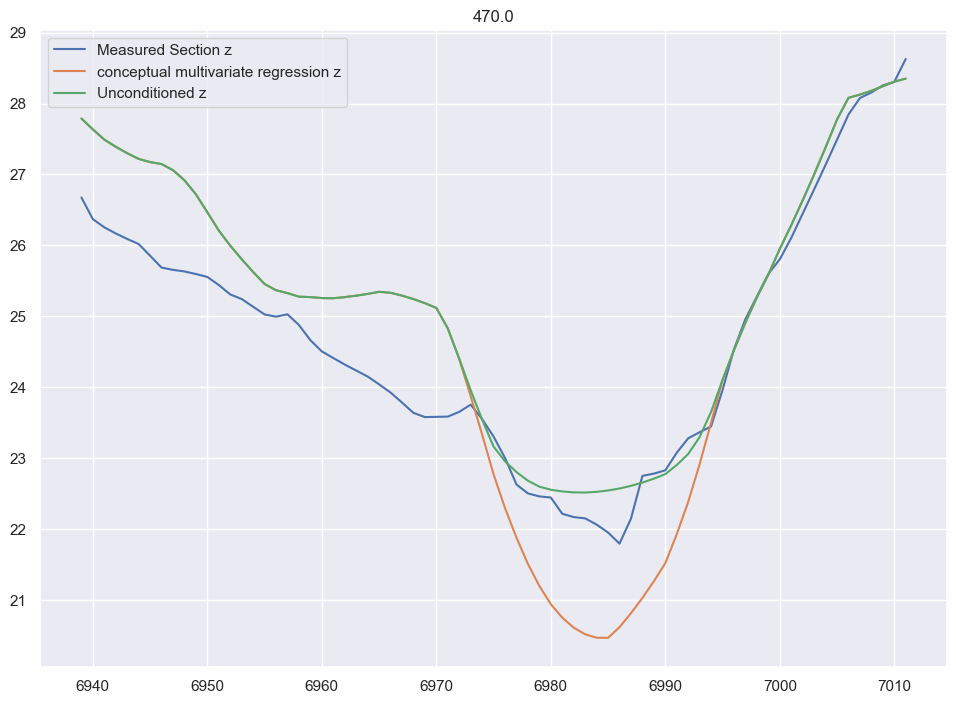

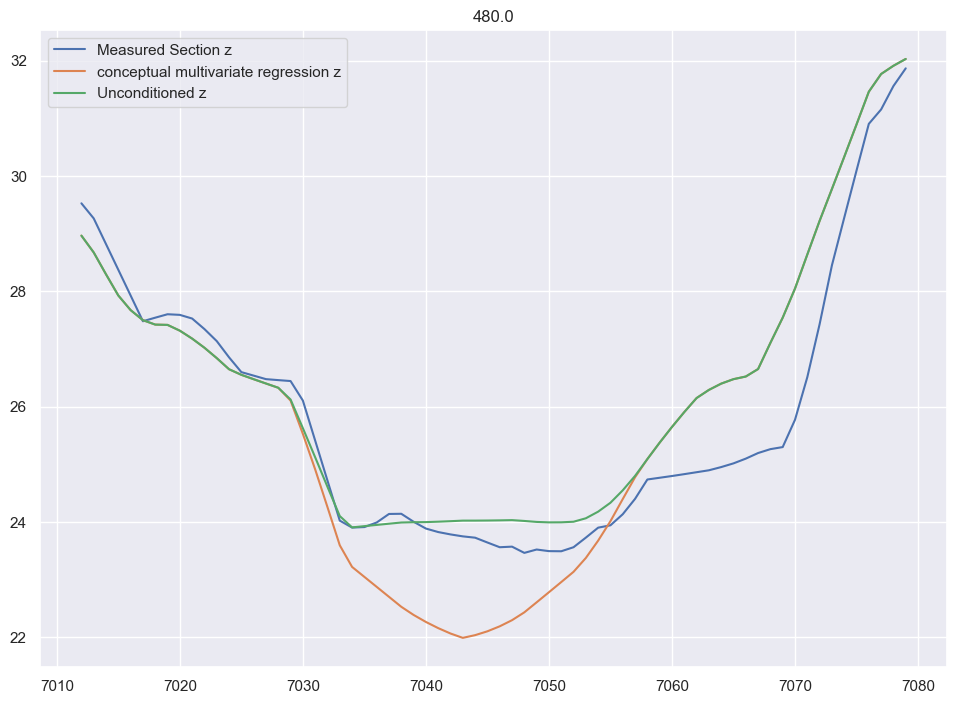

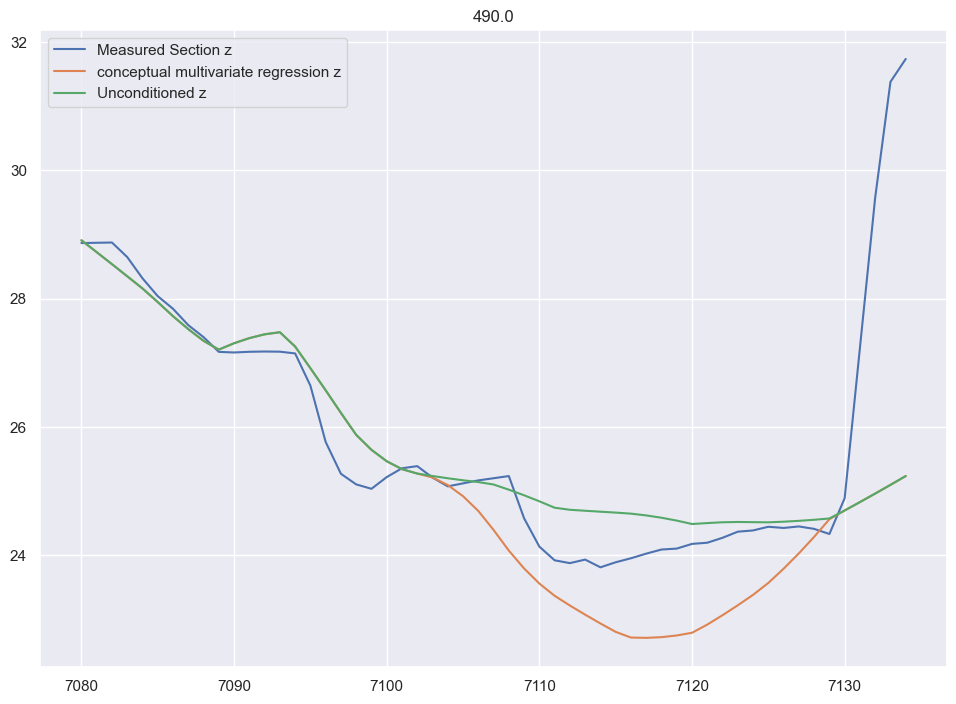

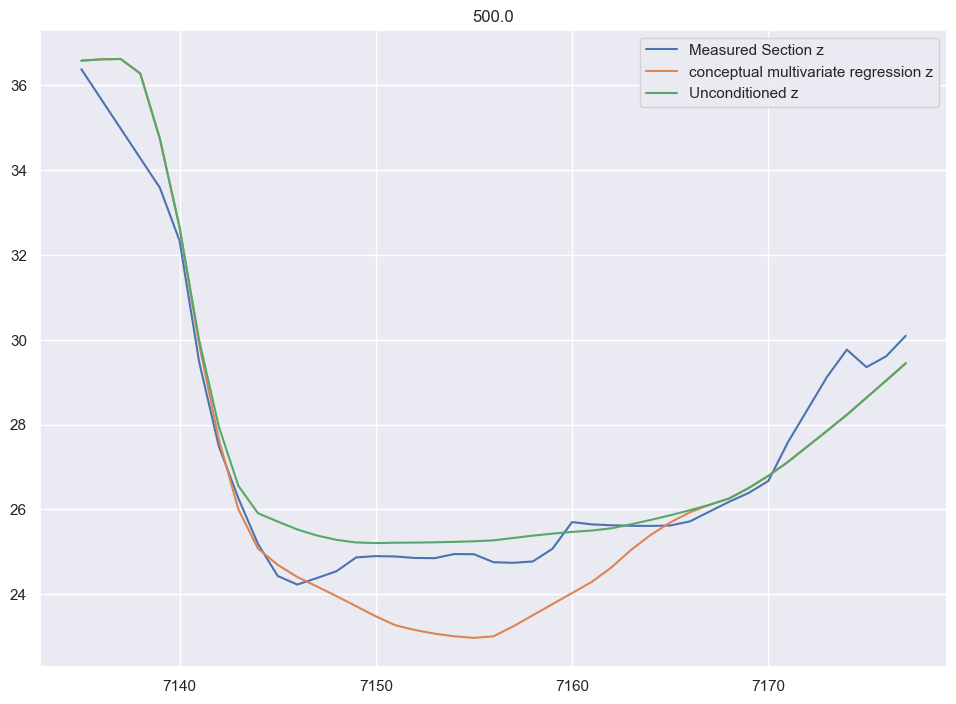

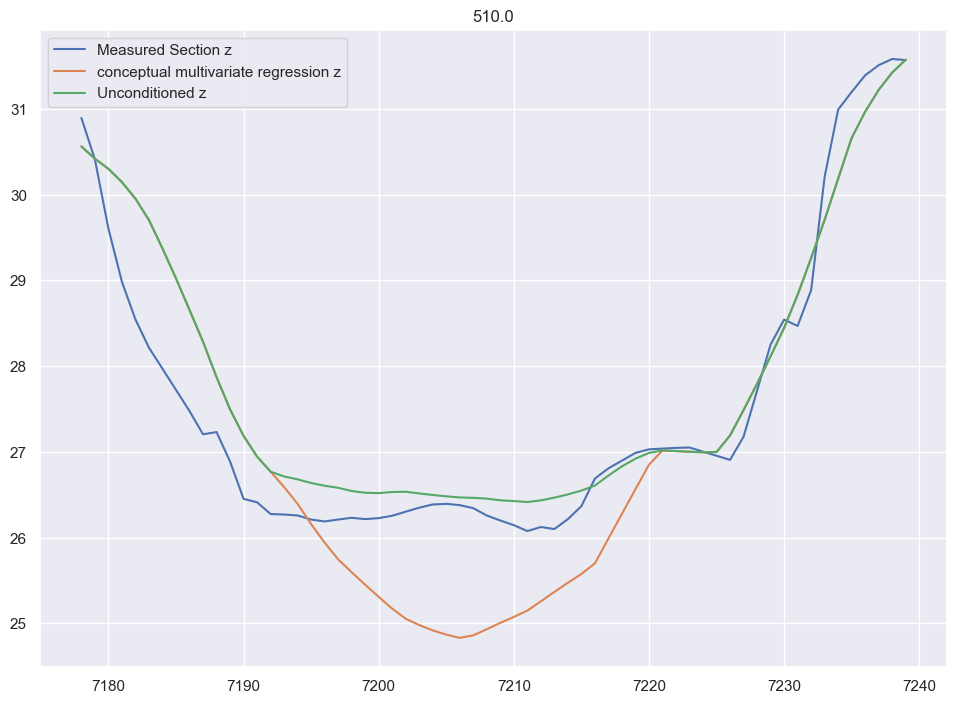

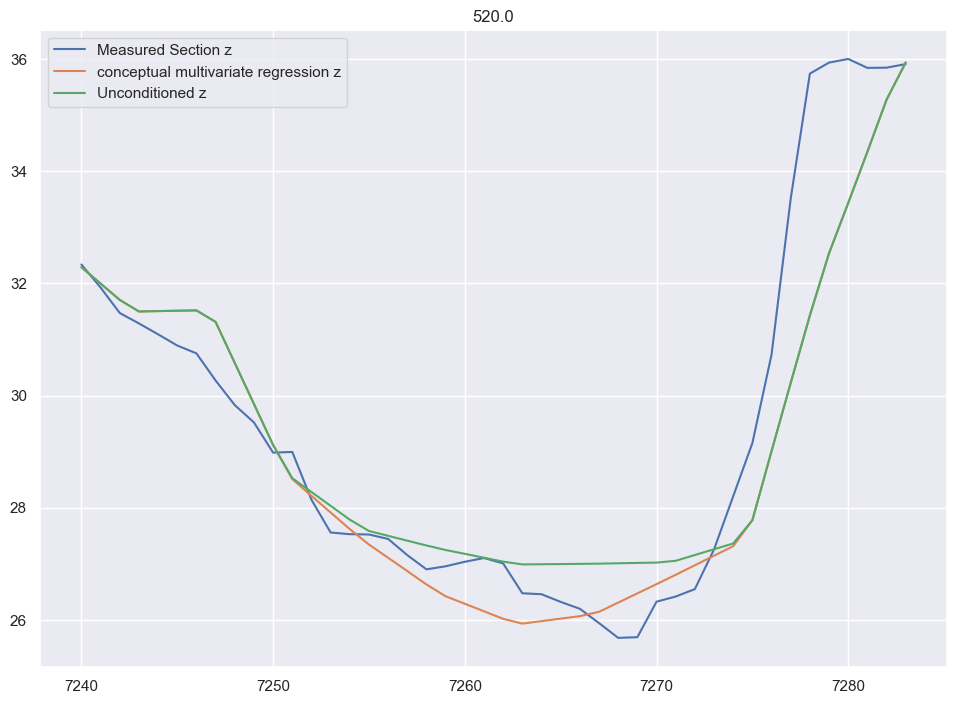

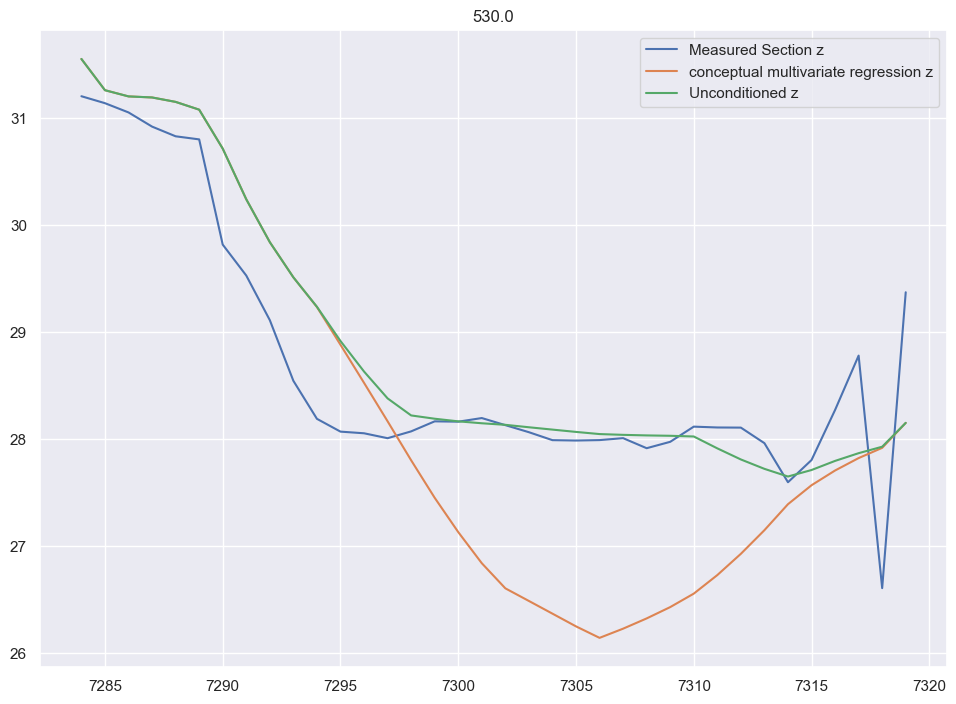

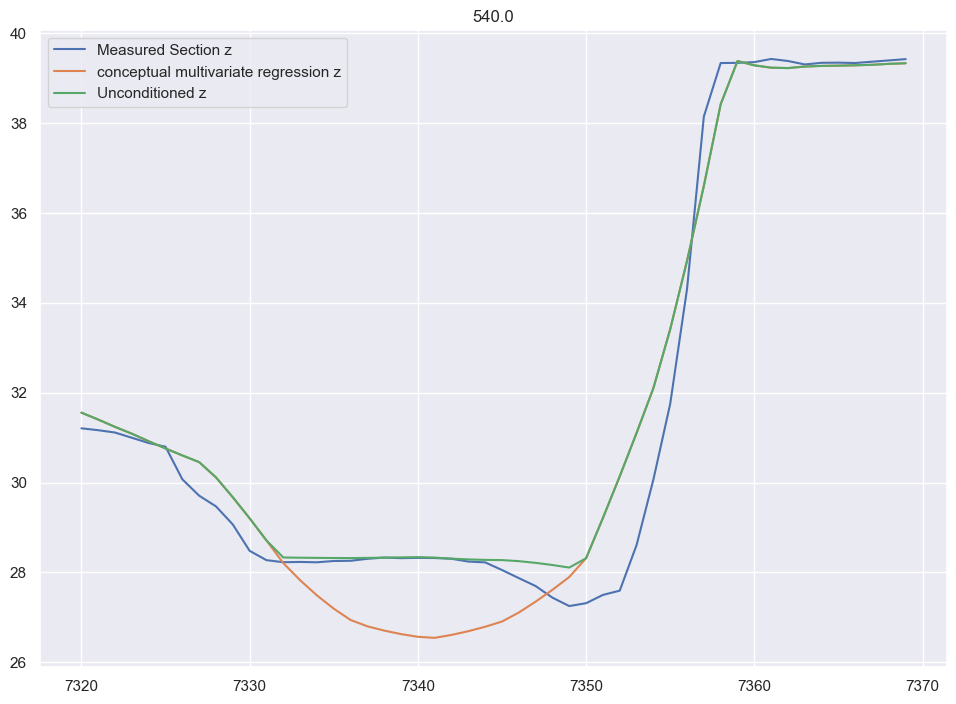

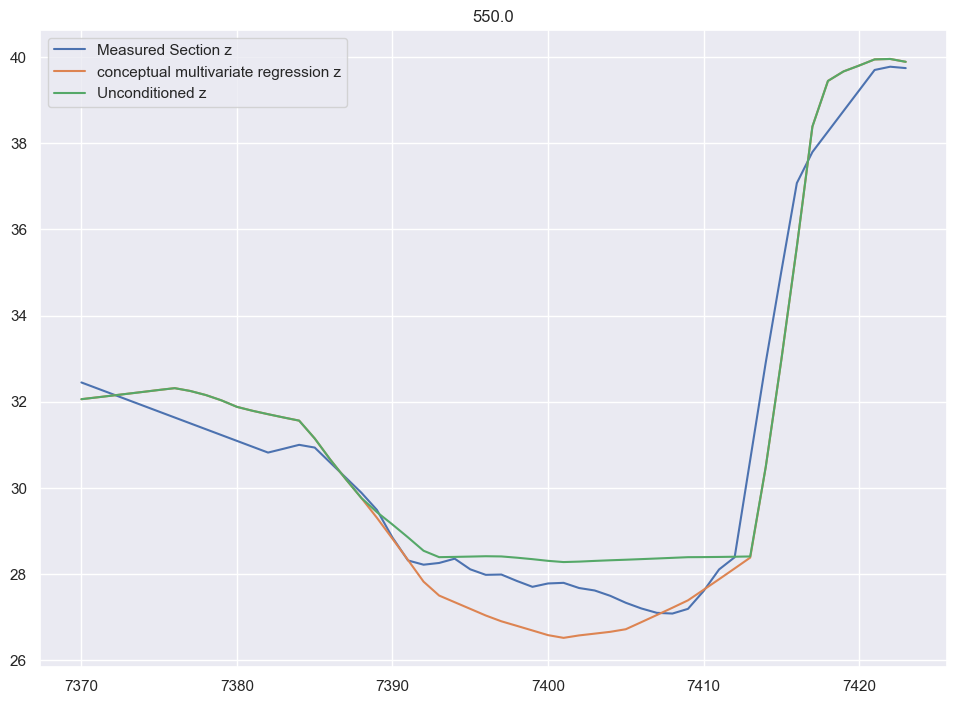

In [65]:
columns = ["Measured Section z"]; columns.extend([f"{key} z" for key in dems])
for section in comparisons_sampled['Section'].unique():
    figure = comparisons_sampled[comparisons_sampled["Section"]==section][columns].plot(title=section)
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / f"{section}.png")
    distance = comparisons_sampled[comparisons_sampled['Section']==section]['Distance Upstream [m]'].iloc[0]
    figure = comparisons_sampled[comparisons_sampled["Section"]==section][columns].plot(title=f"{distance}m upstream.png")
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / "distance_upstream" / f"{distance}m_upstream.png")

C:\Users\pearsonra\Anaconda3\envs\raster\Lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


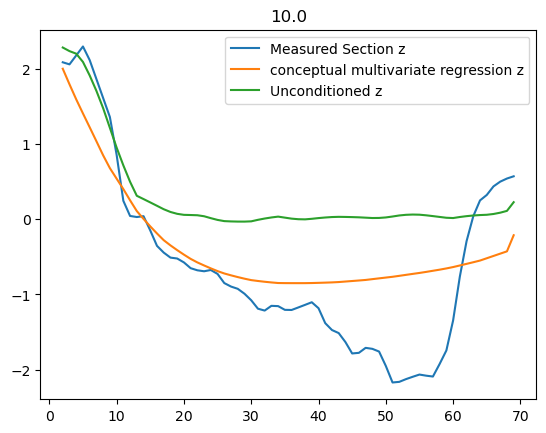

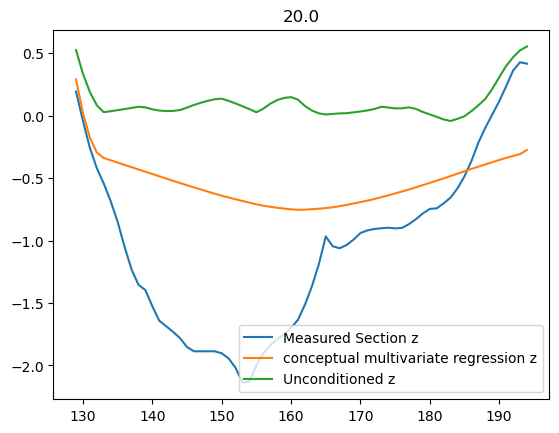

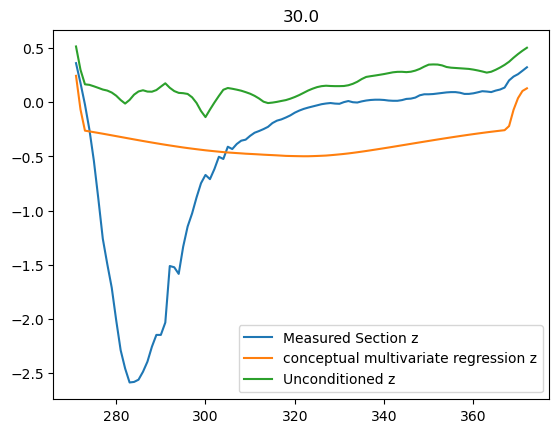

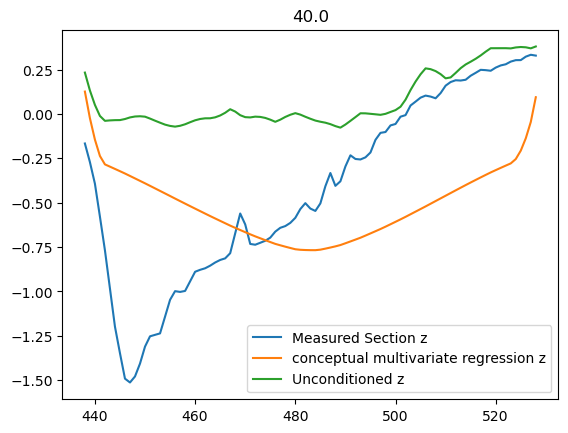

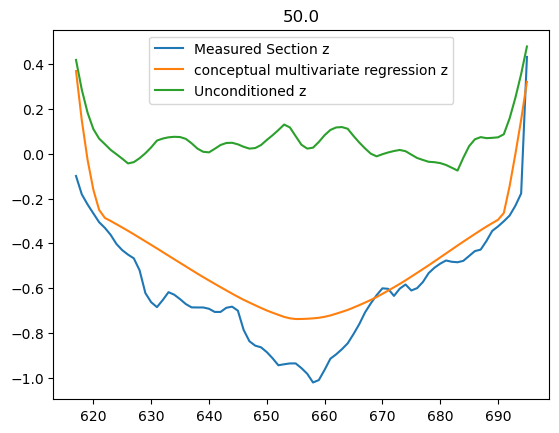

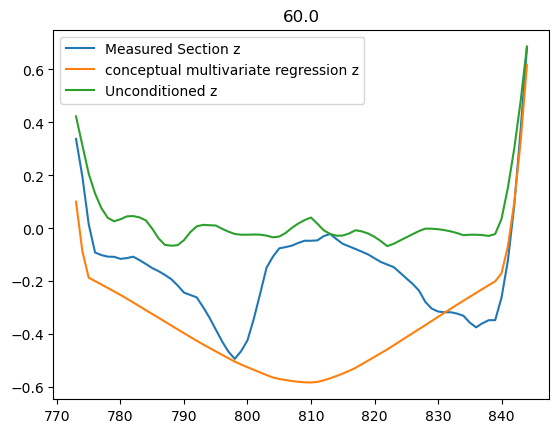

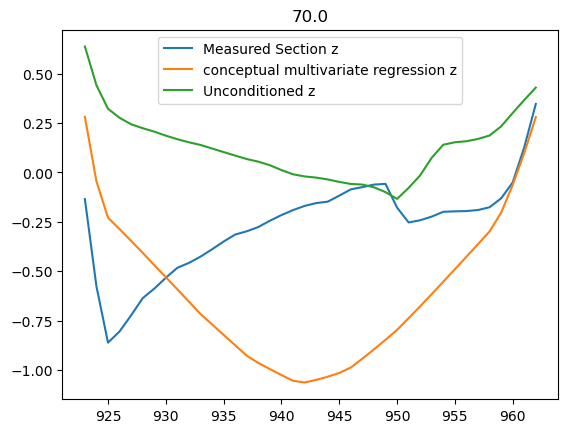

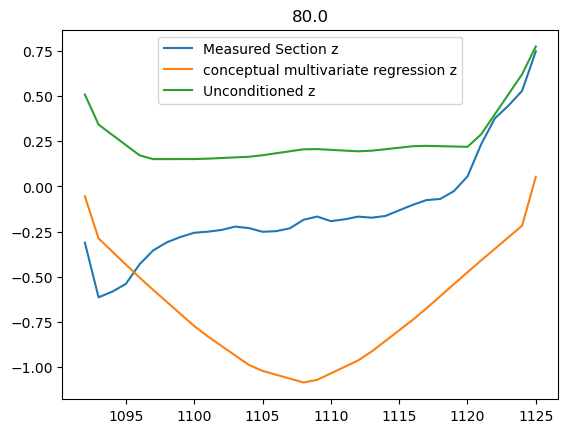

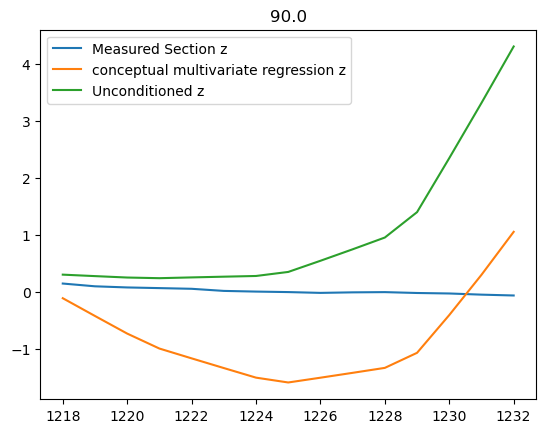

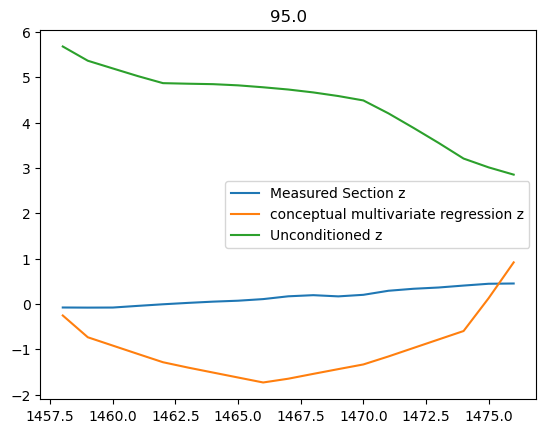

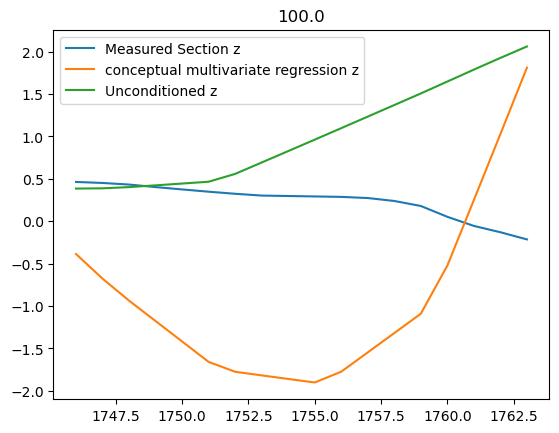

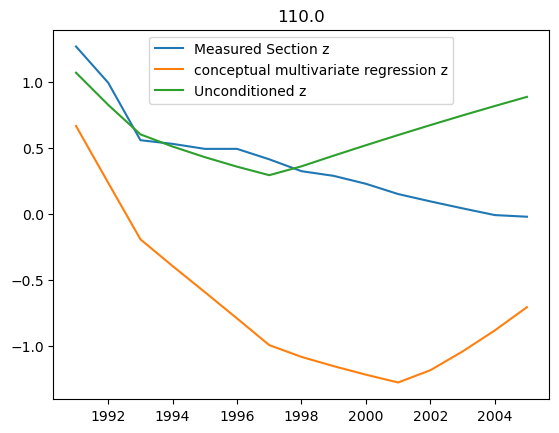

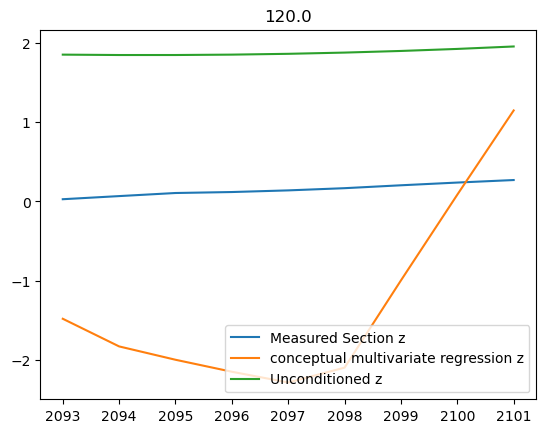

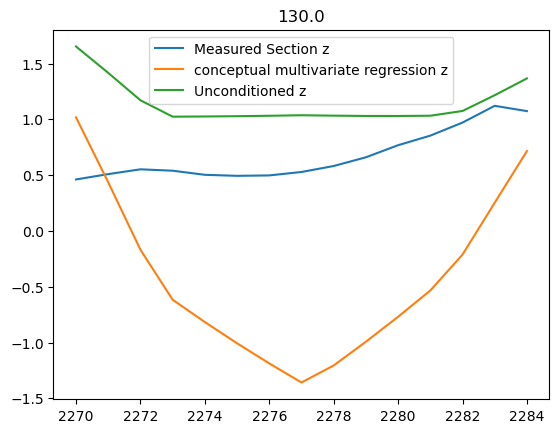

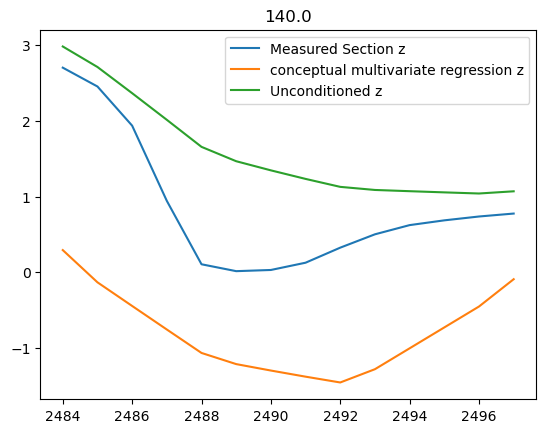

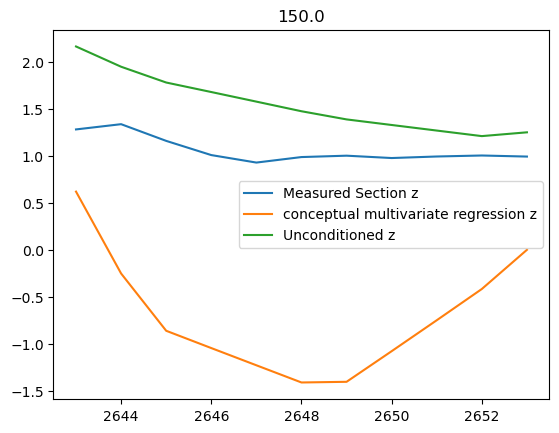

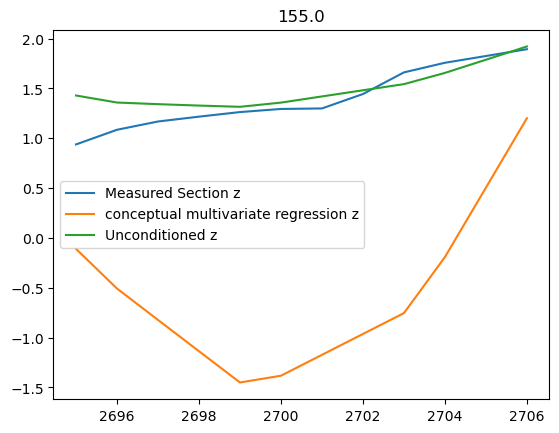

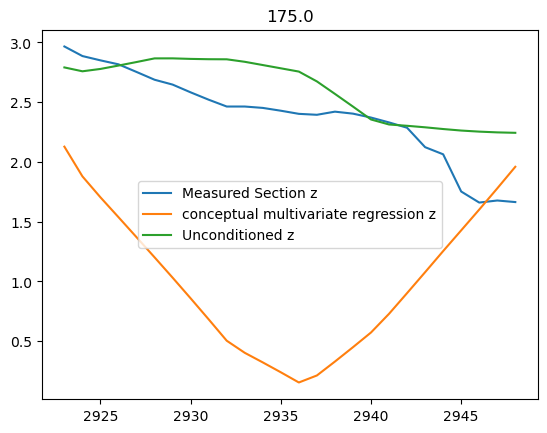

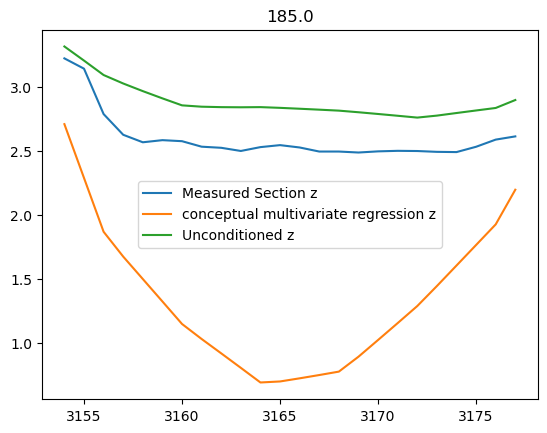

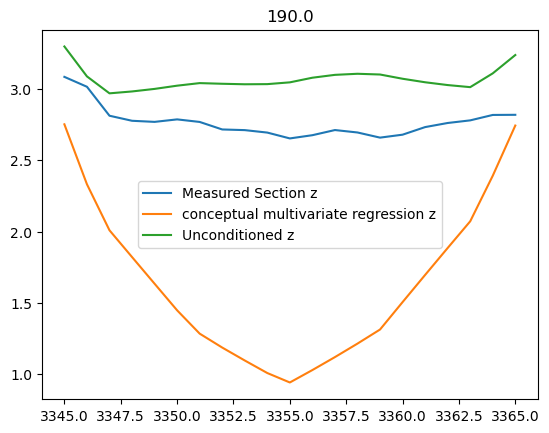

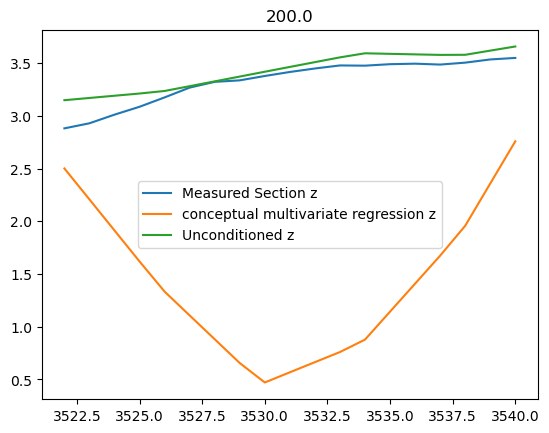

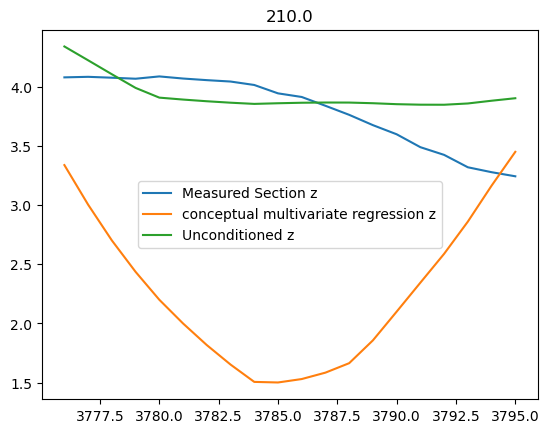

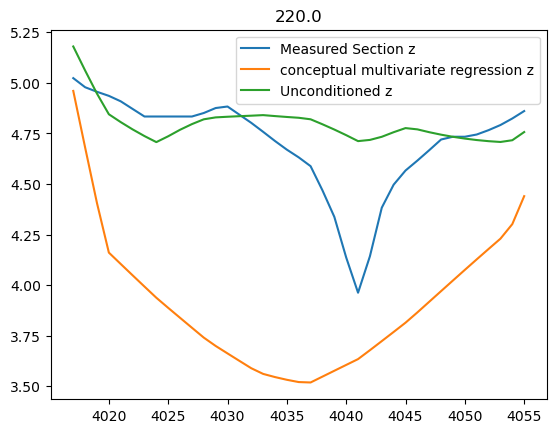

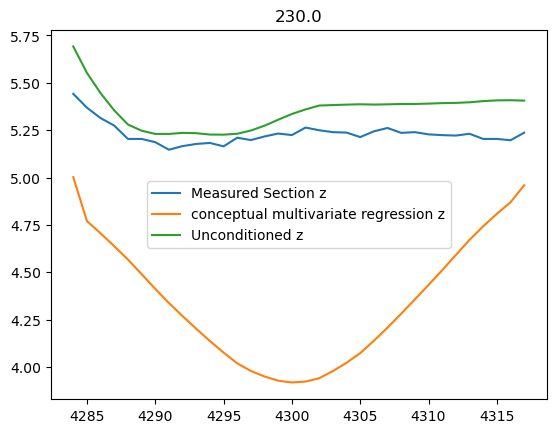

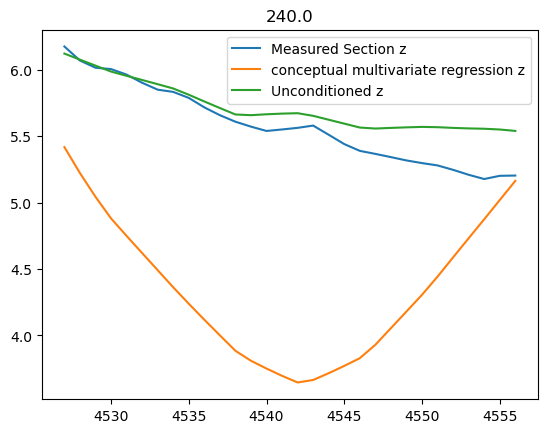

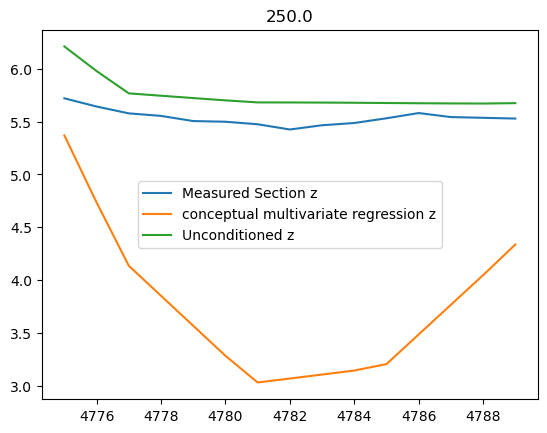

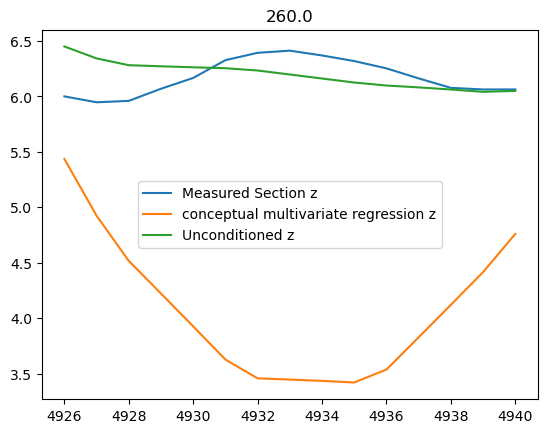

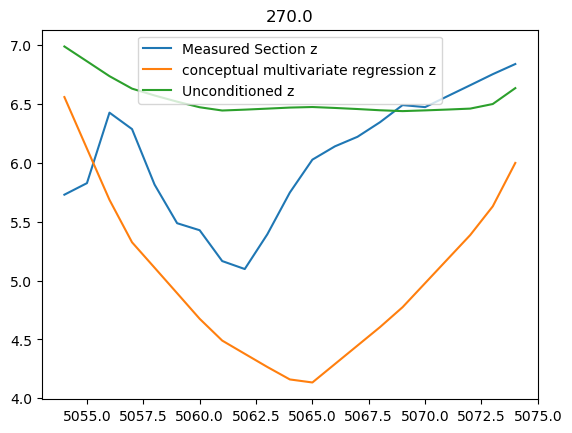

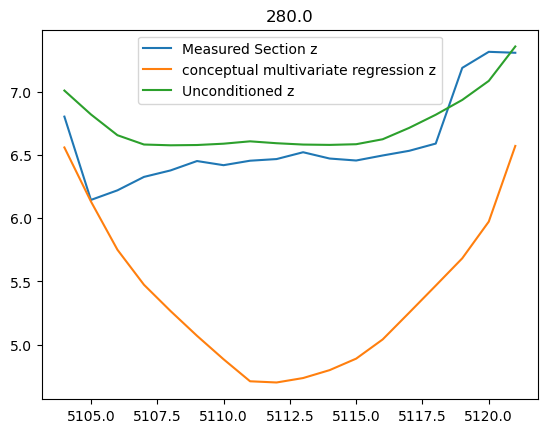

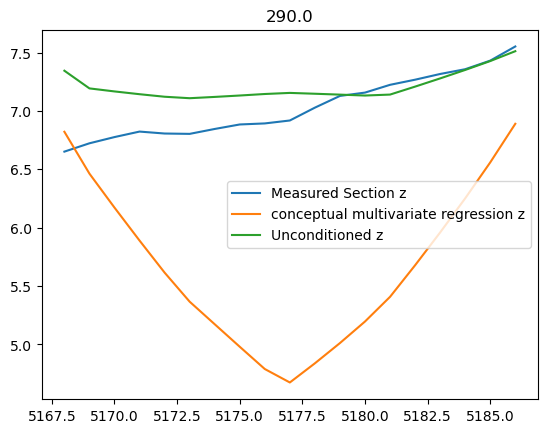

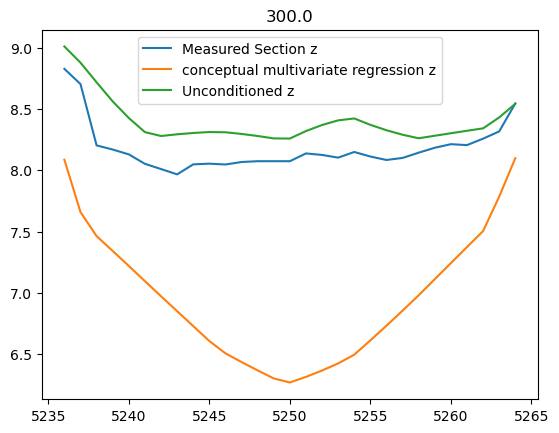

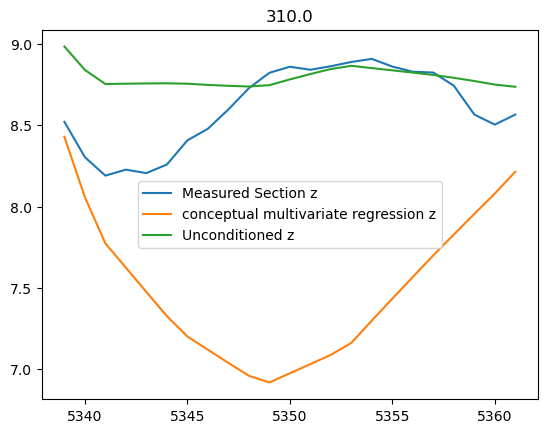

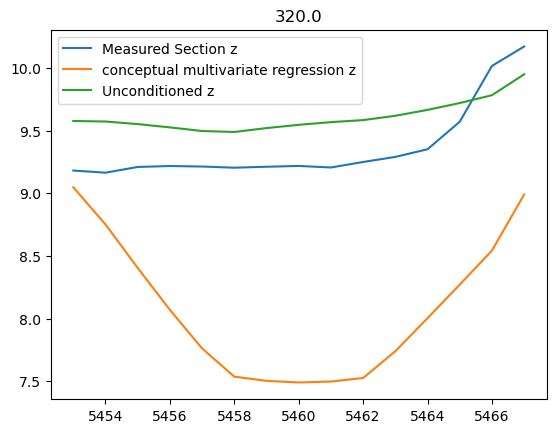

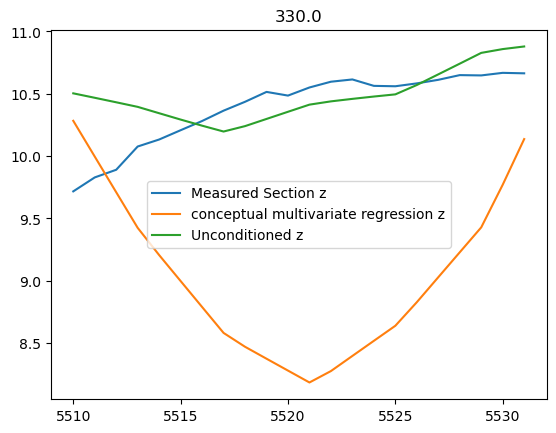

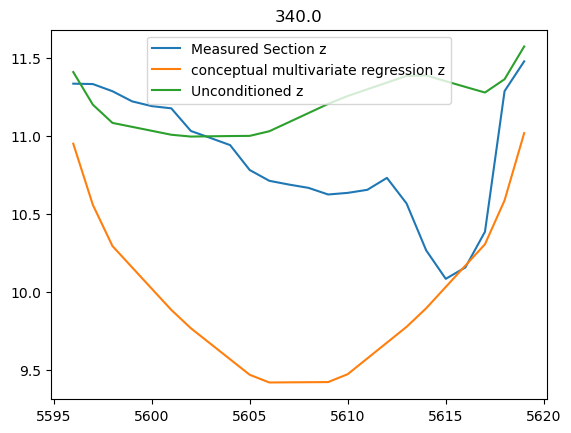

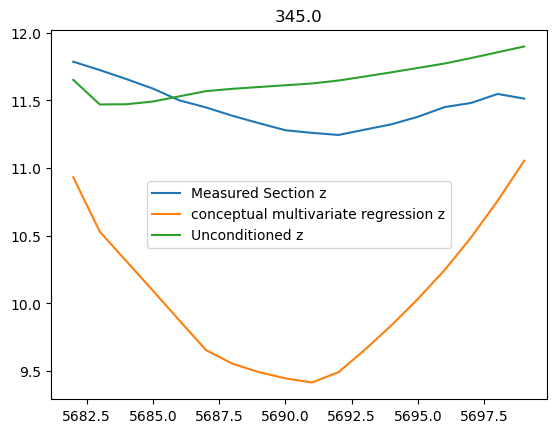

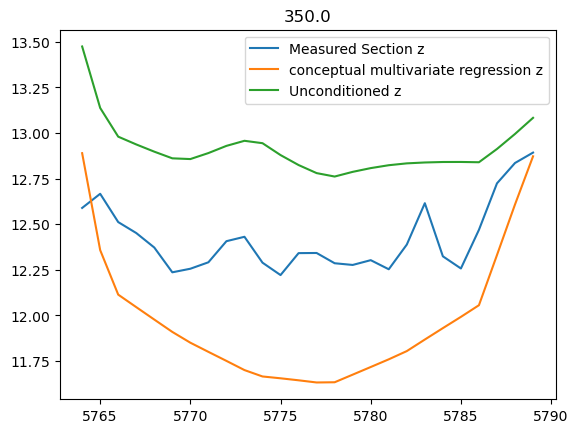

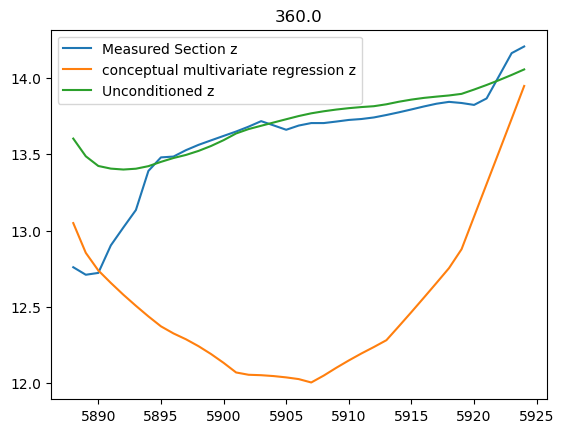

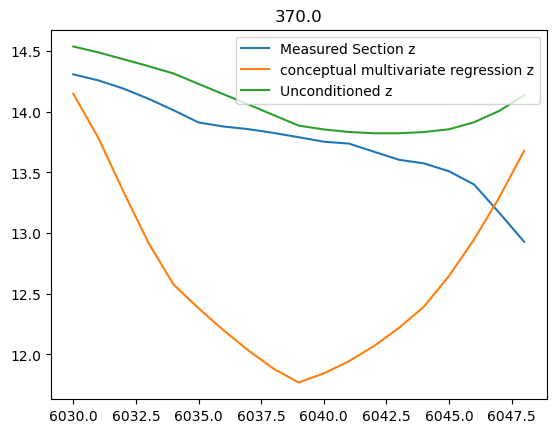

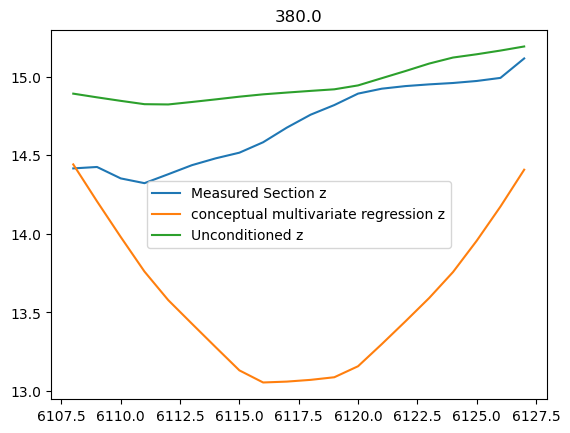

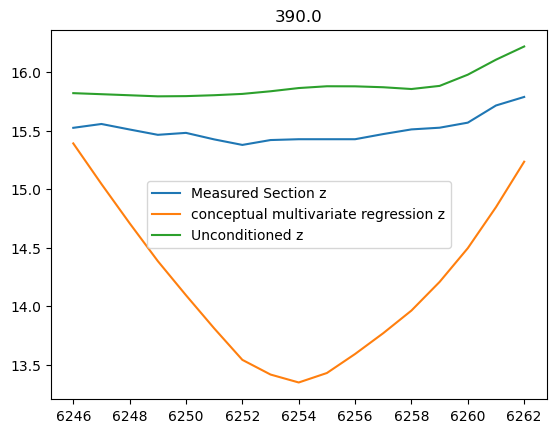

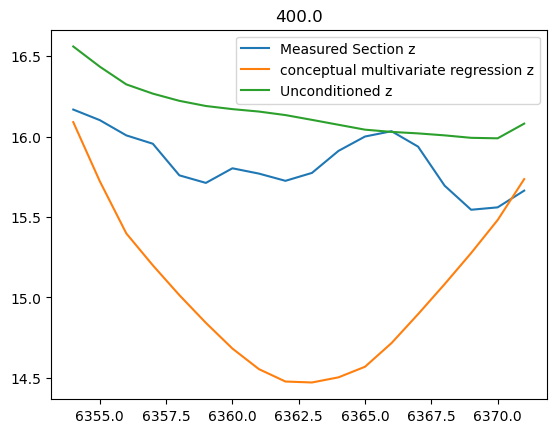

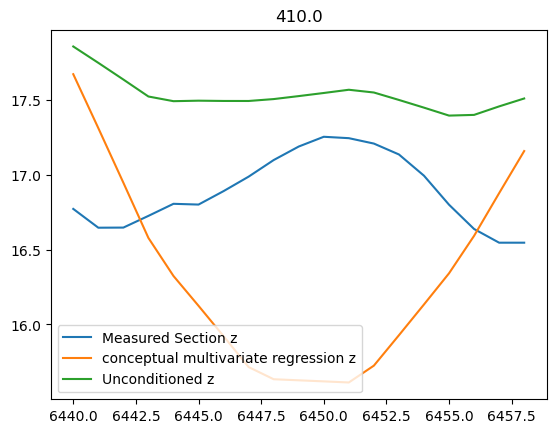

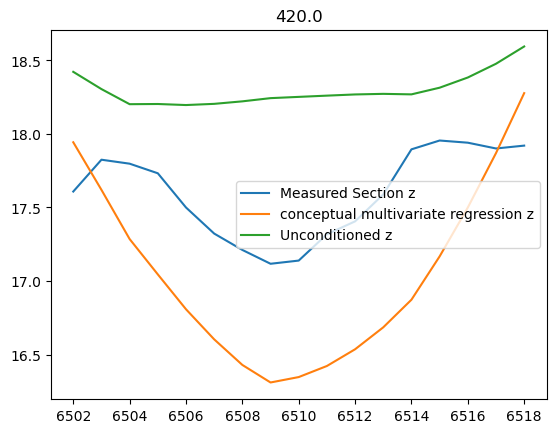

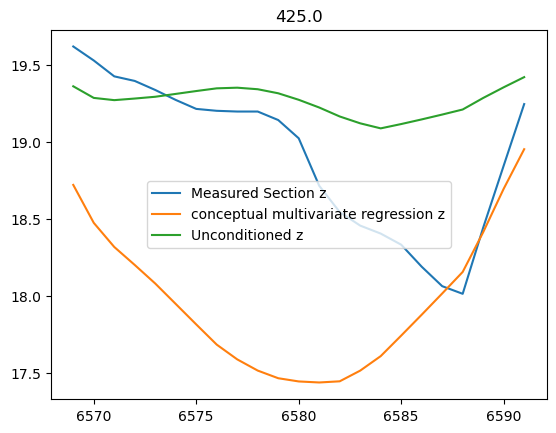

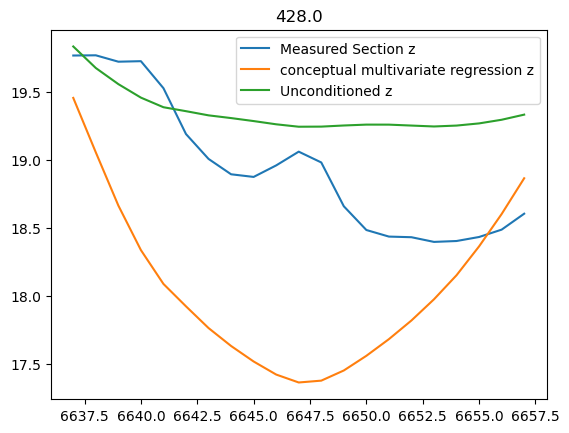

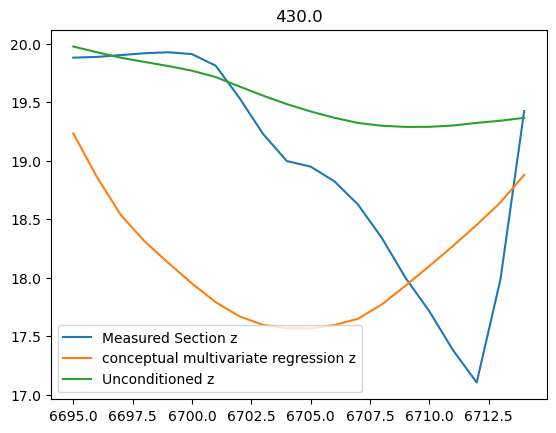

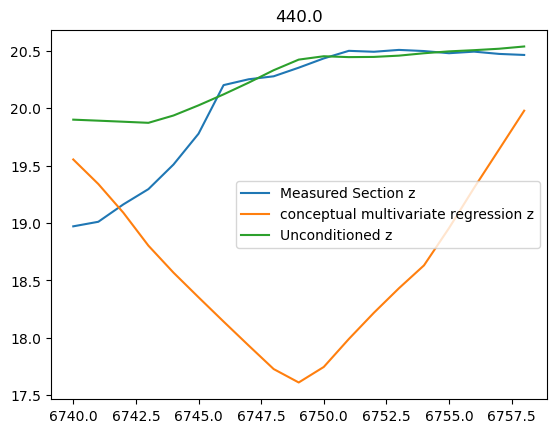

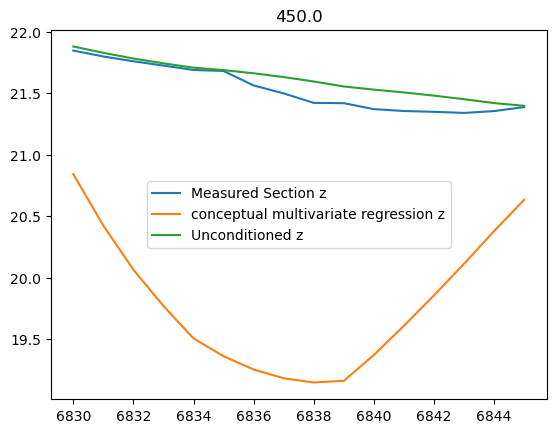

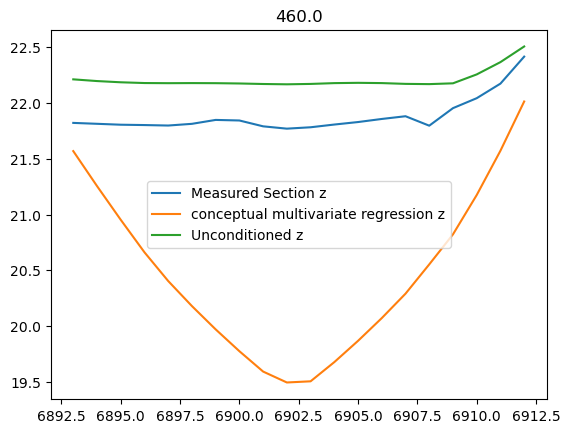

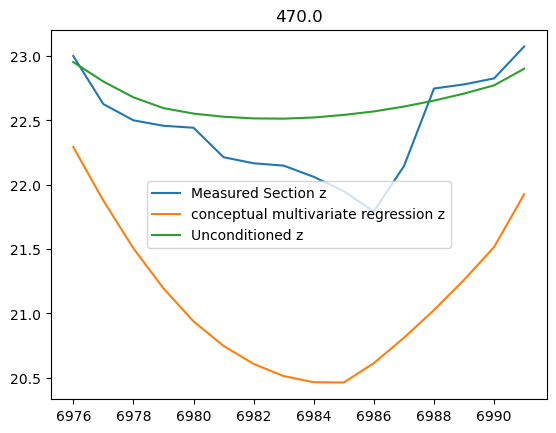

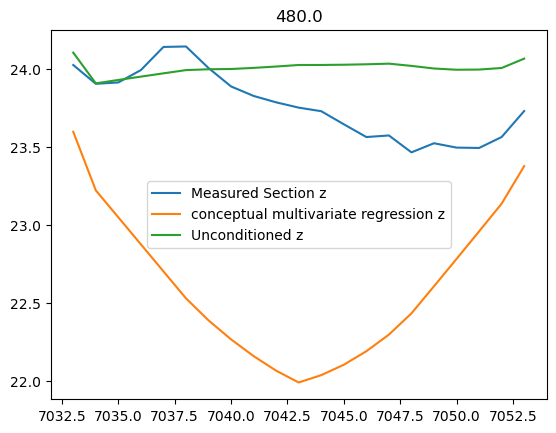

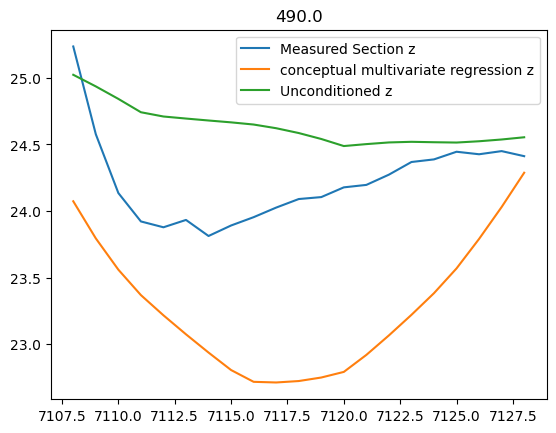

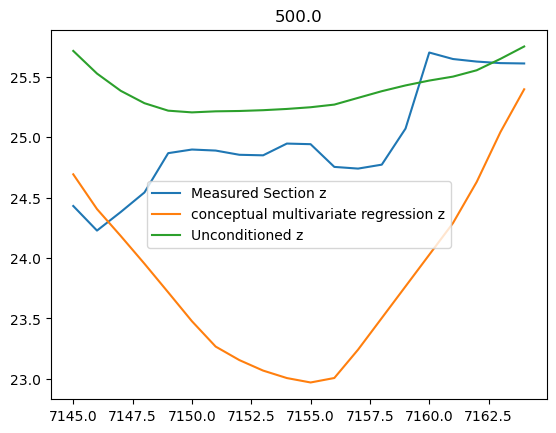

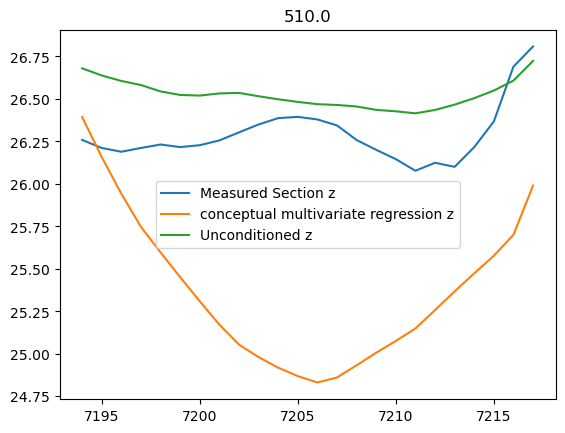

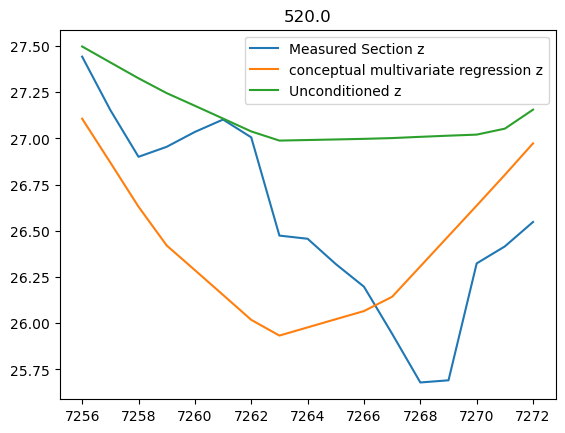

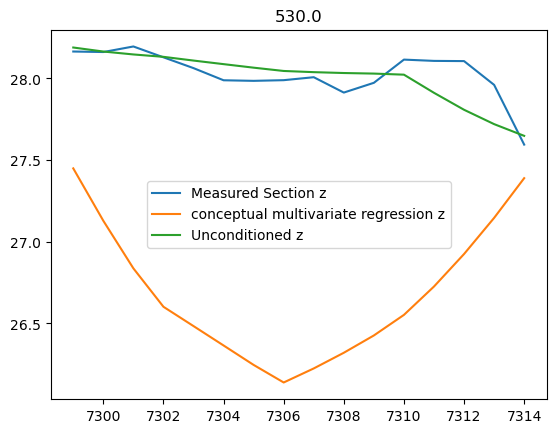

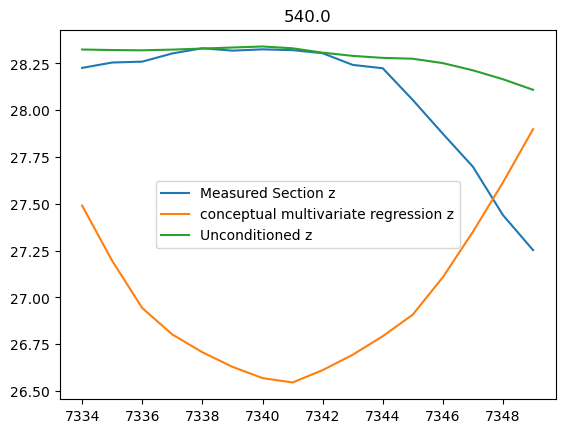

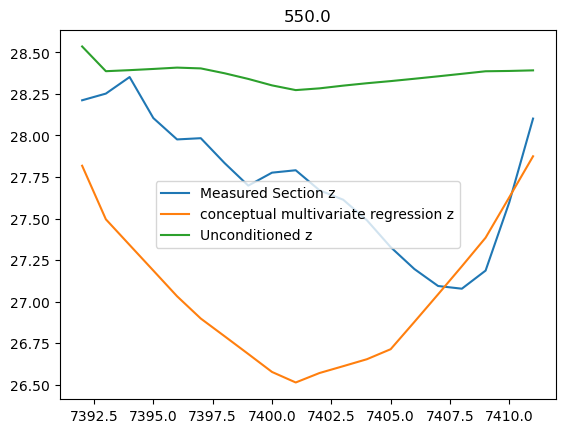

In [25]:
columns = ["Measured Section z"]; columns.extend([f"{key} z" for key in dems])
for section in comparisons_sampled['Section'].unique():
    figure = comparisons_sampled[(comparisons_sampled["Section"]==section) & (comparisons_sampled["River"]==True)][columns].plot(title=section);
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / f"{section}_only_river.png")
    
    distance = comparisons_sampled[comparisons_sampled['Section']==section]['Distance Upstream [m]'].iloc[0]
    figure = comparisons_sampled[(comparisons_sampled["Section"]==section) & (comparisons_sampled["River"]==True)][columns].plot(title=f"{distance}m upstream.png")
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / "distance_upstream" / f"only_river_{distance}m_upstream.png")

## Plot elevation errors along each section
95% confidence interval plot for the errors along each section in the river. 

In [26]:
for key in dems:
    comparisons_sampled[f"{key} Elevation Errors"] = comparisons_sampled[f"{key} z"] - comparisons_sampled["Measured Section z"]

In [27]:
comparisons_sampled.head(1)

conceptual multivariate regression z  Unconditioned z  Measured Section z  \
0                              2.422087         2.422087            2.163331   

   Section  River  Distance Upstream [m]  Offset [m]  \
0     10.0  False               5.905348           0   

   conceptual multivariate regression Elevation Errors  \
0                                           0.258757     

   Unconditioned Elevation Errors  
0                        0.258757

In [116]:
comparisons_for_plotting=comparisons_sampled.rename(
    columns={"Unconditioned DEM Elevation Errors": "Unconditioned DEM", "Conditioned Neal DEM Elevation Errors": "Uniform Flow DEM", "Conditioned Smart DEM Elevation Errors": "Multivariate Regression DEM"}).drop(
    columns=["Unconditioned DEM z", "Conditioned neal DEM z", "Conditioned smart DEM z", "Measured Section z"]).melt(
    id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]")

In [117]:
comparisons_for_plotting.head(1)

Section  Distance Upstream [m]  River  Offset [m]         Comparison  \
0     10.0                    0.0  False           0  Unconditioned DEM   

   Riverbed Elevation Error [m]  
0                     -0.238869

In [28]:
comparisons_for_plotting=comparisons_sampled.drop(
    columns=[f"{key} z" for key in dems]).drop(columns=["Measured Section z"]).rename(
    columns=dict((f"{key} Elevation Errors", f"{key}") for key in dems)).melt(
    id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]")

In [29]:
comparisons_for_plotting.to_json(cache_path / folder / "measured_section_comparison" / "compairson_for_plotting.json")

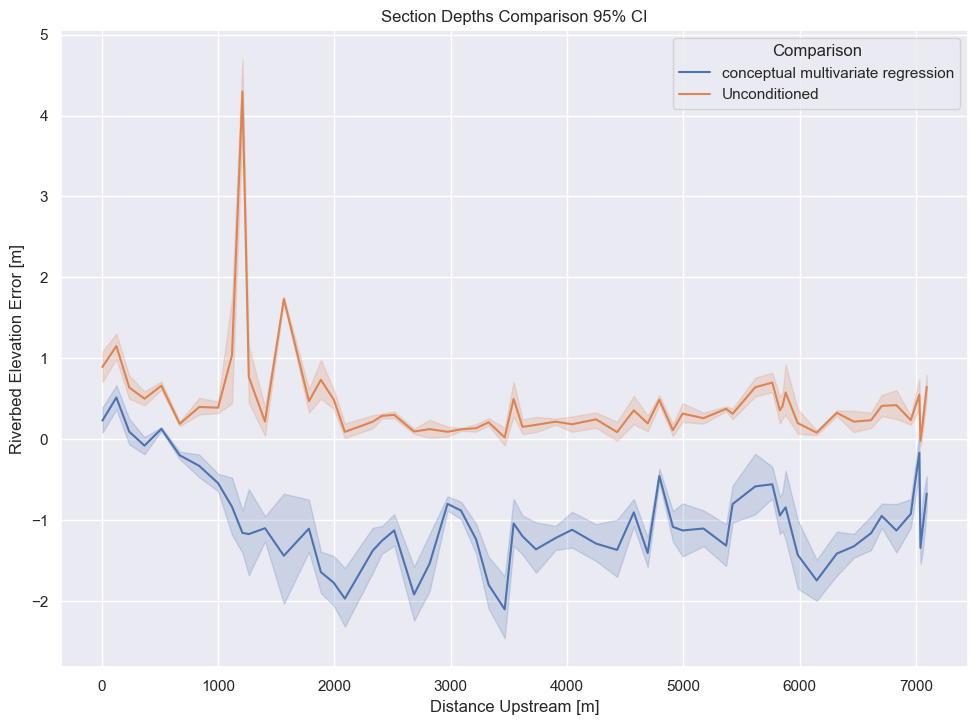

In [30]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=comparisons_for_plotting[comparisons_for_plotting["River"]], x="Distance Upstream [m]", y="Riverbed Elevation Error [m]", hue="Comparison")
figure.set(title='Section Depths Comparison 95% CI')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_depth_errors.png")

In [31]:
summary = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=[f"{key} z" for key in dems]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
depth_summary = pandas.DataFrame([[summary.mean()[f"{key} Elevation Errors"] for key in dems],
                                  [summary.std()[f"{key} Elevation Errors"] for key in dems]],
                                  index = ["Mean Error", "Standard Deviation"], columns=[key for key in dems])
depth_summary

conceptual multivariate regression  Unconditioned
Mean Error                                   -0.730262       0.470184
Standard Deviation                            0.871512       0.664183

# Channel Area error
The total area of the channel at each section

In [32]:
channel_depths = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=[f"{key} Elevation Errors" for key in dems]).drop(columns=["River", "Section"]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
section_max_evaluation = channel_depths.groupby("Distance Upstream [m]")[["Measured Section z"]].max()

In [33]:
channel_depths.head(1)

conceptual multivariate regression z  \
Distance Upstream [m] Offset [m]                                         
5.905348              2                                       2.004279   

                                  Unconditioned z  Measured Section z  
Distance Upstream [m] Offset [m]                                       
5.905348              2                  2.286727            2.090118

In [34]:
# Some hacky code to subtract the max elevation from each column in turn
channel_depths["Measured Section"] = section_max_evaluation - channel_depths[["Measured Section z"]]
for key in dems:
    channel_depths[key] = section_max_evaluation.rename(columns={"Measured Section z": f"{key} z"}) - channel_depths[[f"{key} z"]]
channel_depths.head(1)

conceptual multivariate regression z  \
Distance Upstream [m] Offset [m]                                         
5.905348              2                                       2.004279   

                                  Unconditioned z  Measured Section z  \
Distance Upstream [m] Offset [m]                                        
5.905348              2                  2.286727            2.090118   

                                  Measured Section  \
Distance Upstream [m] Offset [m]                     
5.905348              2                   0.210441   

                                  conceptual multivariate regression  \
Distance Upstream [m] Offset [m]                                       
5.905348              2                                     0.296279   

                                  Unconditioned  
Distance Upstream [m] Offset [m]                 
5.905348              2                0.013831

In [41]:
channel_area = channel_depths.drop(
    columns=["Measured Section z"]).drop(
    columns=[f"{key} z" for key in dems]).groupby("Distance Upstream [m]").sum()
channel_area.head(1)

Measured Section  conceptual multivariate regression  \
Distance Upstream [m]                                                         
5.905348                     196.990028                          181.279347   

                       Unconditioned  
Distance Upstream [m]                 
5.905348                    136.2144

In [42]:
areas_for_plotting=channel_area.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

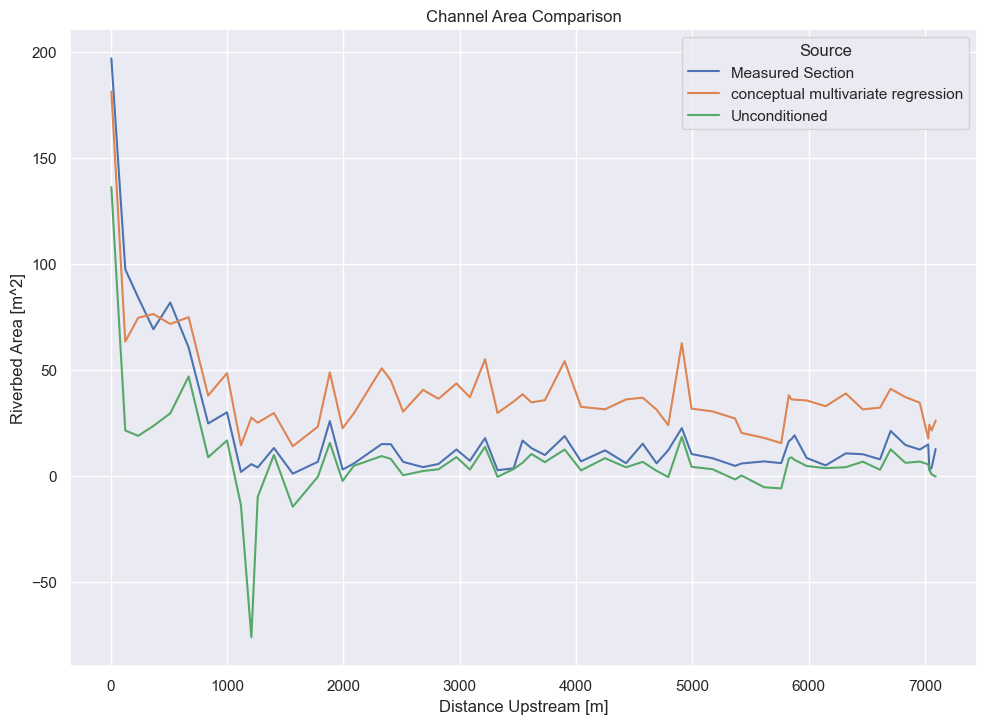

In [43]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=areas_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source")
figure.set(title='Channel Area Comparison')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_area_errors.png") 

In [45]:
channel_area.head(2)

Measured Section  conceptual multivariate regression  \
Distance Upstream [m]                                                         
5.905348                     196.990028                          181.279347   
125.812070                    97.459446                           63.431387   

                       Unconditioned  
Distance Upstream [m]                 
5.905348                  136.214400  
125.812070                 21.459855

In [47]:
area_summary = pandas.DataFrame([[channel_area.mean()[key] for key in dems],
                                  [channel_area.std()[key] for key in dems]],
                                  index = ["Mean Error", "Standard Deviation"], columns=[key for key in dems])
area_summary

conceptual multivariate regression  Unconditioned
Mean Error                                   39.197981       7.152168
Standard Deviation                           23.892219      22.349575

# Exploring potential sources of error

## 1. Using measured versus estimate flow
The flow guage stations provide measured mean-annual flood flows. These can be used instead of the estimated ones across NZ. We can look at the impact of the different values by simply scaling the depths and then rerunning the generate hydrologically conditioned DEM steps.

#### Measured flow guage data
* [Waikanae water treatment plant](https://www.lawa.org.nz/explore-data/wellington-region/water-quantity/monitoring-sites/waikanae-river-at-water-treatment-plant/) - 159.00 m³/s

#### Estimated flow data
* Waikanae water treatment plant section NZREACH ID 9004262 - 145.30 m³/s

#### Scaling to the different depths
In both cases the equation can be re-arragned to: h=(n/wS^b)^1/(1+a)*Q^1/(1+a) where 1/(1+a) differs in each case.
So depth can be scaled by (Qmeasured/Qold) ^ 1/(1+a). Where Qmeasured/Qold = 1.0942876806607018.
This means in each case:
* Uniform flow - 1/(1+a) = 0.6 -> x 1.0555502331582127
* Conceptual multivariate regression - 1/(1+a) = 0.573 -> x 1.0529854137135457
So depth can be scaled by (Qmeasured/Qold) ^ 1/(1+a)
*So hardly any change at all*

## 2. Different thresholds
##### Currently
* narrow is 0.5 min to 0.75 max
* wide is 2 min to 5 max
Looking through the sampled sections it looks like the banks are higher than  5m generally (at least for bank full flow), and the water section could be less than 2m - try say 1m min, 10 max

## 3. Turn off the depth adjustment
#### Currently 
* My code for adjusting the depth estimate based on the banks doesn't seem to be quite right!
* It also makes the rivers deeper which is not desired based on a comparison to the sections
#### Future
Drope out this 'correction' as an unneeded complexity at this stage. 

## 4. Could add a proportion flowing through sediment
In braided rivers most or even all flow can be through the river gravels. 

#### Future
1. Could add a user specified 'proportion of flow in sediments' 
2. May just want to keep at it is as trying to make a 'hydrologically conditioned DEM' as opposed to the actual measured cross sections.

Questions: are their models where would want the actual bed elevation as they model the flow through the gravels - I think so - sediment transport models